# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

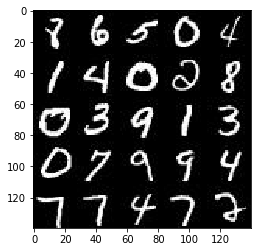

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

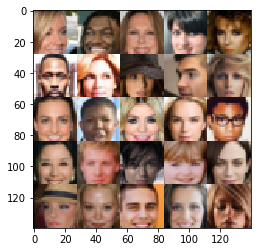

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/tapanm01/anaconda2/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='Real_Input')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='Z_input')
    learning_rate = tf.placeholder(tf.float32, name='Learning_Rate')

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(0.2 * x1, x1)
        relu1 = tf.nn.dropout(relu1,0.9)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        relu2 = tf.nn.dropout(relu2,0.9)

        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        relu3 = tf.nn.dropout(relu3,0.9)

        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)


    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01 * x1, x1)
        x1 = tf.nn.dropout(x1,0.9)

        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.01 * x2, x2)
        x2 = tf.nn.dropout(x2,0.9)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.01 * x3, x3)
        x3 = tf.nn.dropout(x3,0.9)
        # 28x28x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)

    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - 0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    

    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2.0

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Steps {}    ".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Steps 10     Discriminator Loss: 1.1057... Generator Loss: 1.0333
Epoch 1/2... Steps 20     Discriminator Loss: 0.4964... Generator Loss: 9.2317
Epoch 1/2... Steps 30     Discriminator Loss: 0.9862... Generator Loss: 0.8385
Epoch 1/2... Steps 40     Discriminator Loss: 1.2833... Generator Loss: 0.6397
Epoch 1/2... Steps 50     Discriminator Loss: 2.2049... Generator Loss: 0.2164
Epoch 1/2... Steps 60     Discriminator Loss: 0.5085... Generator Loss: 3.0225
Epoch 1/2... Steps 70     Discriminator Loss: 1.0749... Generator Loss: 0.8299
Epoch 1/2... Steps 80     Discriminator Loss: 1.0617... Generator Loss: 3.7484
Epoch 1/2... Steps 90     Discriminator Loss: 2.0611... Generator Loss: 0.8468
Epoch 1/2... Steps 100     Discriminator Loss: 1.6016... Generator Loss: 0.7083


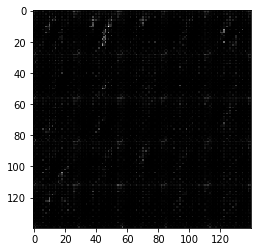

Epoch 1/2... Steps 110     Discriminator Loss: 1.1356... Generator Loss: 1.3139
Epoch 1/2... Steps 120     Discriminator Loss: 1.1732... Generator Loss: 1.7439
Epoch 1/2... Steps 130     Discriminator Loss: 1.5149... Generator Loss: 2.3341
Epoch 1/2... Steps 140     Discriminator Loss: 1.7143... Generator Loss: 0.4828
Epoch 1/2... Steps 150     Discriminator Loss: 1.4977... Generator Loss: 0.5785
Epoch 1/2... Steps 160     Discriminator Loss: 1.2016... Generator Loss: 0.7386
Epoch 1/2... Steps 170     Discriminator Loss: 1.2085... Generator Loss: 0.7746
Epoch 1/2... Steps 180     Discriminator Loss: 1.5184... Generator Loss: 1.1413
Epoch 1/2... Steps 190     Discriminator Loss: 1.5931... Generator Loss: 0.5135
Epoch 1/2... Steps 200     Discriminator Loss: 1.4461... Generator Loss: 0.8608


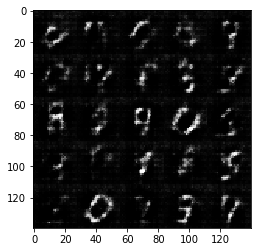

Epoch 1/2... Steps 210     Discriminator Loss: 1.4237... Generator Loss: 1.2711
Epoch 1/2... Steps 220     Discriminator Loss: 1.4073... Generator Loss: 0.9931
Epoch 1/2... Steps 230     Discriminator Loss: 1.6507... Generator Loss: 1.3404
Epoch 1/2... Steps 240     Discriminator Loss: 1.5722... Generator Loss: 1.3808
Epoch 1/2... Steps 250     Discriminator Loss: 1.4041... Generator Loss: 0.8024
Epoch 1/2... Steps 260     Discriminator Loss: 1.6030... Generator Loss: 0.4845
Epoch 1/2... Steps 270     Discriminator Loss: 1.6128... Generator Loss: 1.0368
Epoch 1/2... Steps 280     Discriminator Loss: 1.2620... Generator Loss: 0.8016
Epoch 1/2... Steps 290     Discriminator Loss: 1.3490... Generator Loss: 0.6589
Epoch 1/2... Steps 300     Discriminator Loss: 1.2364... Generator Loss: 1.0077


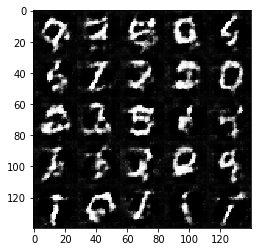

Epoch 1/2... Steps 310     Discriminator Loss: 1.7126... Generator Loss: 1.4124
Epoch 1/2... Steps 320     Discriminator Loss: 1.4484... Generator Loss: 0.4822
Epoch 1/2... Steps 330     Discriminator Loss: 1.3201... Generator Loss: 0.7836
Epoch 1/2... Steps 340     Discriminator Loss: 1.2542... Generator Loss: 1.0580
Epoch 1/2... Steps 350     Discriminator Loss: 1.3081... Generator Loss: 0.8897
Epoch 1/2... Steps 360     Discriminator Loss: 1.3730... Generator Loss: 0.6394
Epoch 1/2... Steps 370     Discriminator Loss: 1.7181... Generator Loss: 0.3758
Epoch 1/2... Steps 380     Discriminator Loss: 1.3593... Generator Loss: 0.7037
Epoch 1/2... Steps 390     Discriminator Loss: 1.2833... Generator Loss: 0.8065
Epoch 1/2... Steps 400     Discriminator Loss: 1.5361... Generator Loss: 0.4678


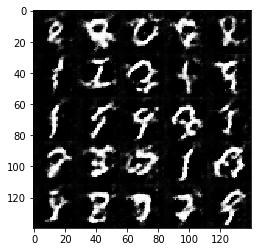

Epoch 1/2... Steps 410     Discriminator Loss: 1.3206... Generator Loss: 0.9634
Epoch 1/2... Steps 420     Discriminator Loss: 1.3183... Generator Loss: 0.9442
Epoch 1/2... Steps 430     Discriminator Loss: 1.4248... Generator Loss: 1.0696
Epoch 1/2... Steps 440     Discriminator Loss: 1.2818... Generator Loss: 0.9820
Epoch 1/2... Steps 450     Discriminator Loss: 1.3020... Generator Loss: 0.6453
Epoch 1/2... Steps 460     Discriminator Loss: 1.5883... Generator Loss: 0.3922
Epoch 1/2... Steps 470     Discriminator Loss: 1.1579... Generator Loss: 0.8787
Epoch 1/2... Steps 480     Discriminator Loss: 1.3962... Generator Loss: 0.5594
Epoch 1/2... Steps 490     Discriminator Loss: 1.3422... Generator Loss: 0.8046
Epoch 1/2... Steps 500     Discriminator Loss: 1.3206... Generator Loss: 0.6155


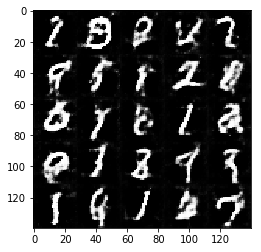

Epoch 1/2... Steps 510     Discriminator Loss: 1.5669... Generator Loss: 0.4181
Epoch 1/2... Steps 520     Discriminator Loss: 1.3871... Generator Loss: 1.4041
Epoch 1/2... Steps 530     Discriminator Loss: 1.3994... Generator Loss: 0.6206
Epoch 1/2... Steps 540     Discriminator Loss: 1.7506... Generator Loss: 0.3114
Epoch 1/2... Steps 550     Discriminator Loss: 1.2768... Generator Loss: 0.6666
Epoch 1/2... Steps 560     Discriminator Loss: 1.3293... Generator Loss: 1.1557
Epoch 1/2... Steps 570     Discriminator Loss: 1.2341... Generator Loss: 1.0804
Epoch 1/2... Steps 580     Discriminator Loss: 1.4515... Generator Loss: 1.5632
Epoch 1/2... Steps 590     Discriminator Loss: 1.3145... Generator Loss: 0.8380
Epoch 1/2... Steps 600     Discriminator Loss: 1.3921... Generator Loss: 0.6197


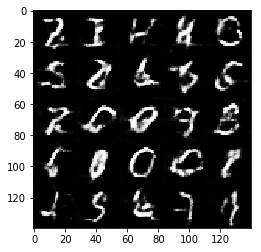

Epoch 1/2... Steps 610     Discriminator Loss: 1.3079... Generator Loss: 0.6109
Epoch 1/2... Steps 620     Discriminator Loss: 1.3443... Generator Loss: 1.5381
Epoch 1/2... Steps 630     Discriminator Loss: 1.2944... Generator Loss: 0.7144
Epoch 1/2... Steps 640     Discriminator Loss: 1.3284... Generator Loss: 0.7108
Epoch 1/2... Steps 650     Discriminator Loss: 1.2348... Generator Loss: 0.7261
Epoch 1/2... Steps 660     Discriminator Loss: 1.3686... Generator Loss: 0.8971
Epoch 1/2... Steps 670     Discriminator Loss: 1.2399... Generator Loss: 0.9968
Epoch 1/2... Steps 680     Discriminator Loss: 1.8594... Generator Loss: 0.3053
Epoch 1/2... Steps 690     Discriminator Loss: 1.2352... Generator Loss: 0.8807
Epoch 1/2... Steps 700     Discriminator Loss: 1.3874... Generator Loss: 0.6496


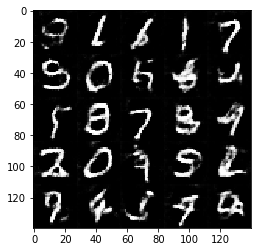

Epoch 1/2... Steps 710     Discriminator Loss: 1.8504... Generator Loss: 1.9430
Epoch 1/2... Steps 720     Discriminator Loss: 1.4420... Generator Loss: 0.5426
Epoch 1/2... Steps 730     Discriminator Loss: 1.4223... Generator Loss: 0.5490
Epoch 1/2... Steps 740     Discriminator Loss: 1.3543... Generator Loss: 0.6741
Epoch 1/2... Steps 750     Discriminator Loss: 1.2918... Generator Loss: 0.9793
Epoch 1/2... Steps 760     Discriminator Loss: 1.2815... Generator Loss: 0.7278
Epoch 1/2... Steps 770     Discriminator Loss: 1.3317... Generator Loss: 0.6046
Epoch 1/2... Steps 780     Discriminator Loss: 1.2430... Generator Loss: 1.0178
Epoch 1/2... Steps 790     Discriminator Loss: 1.3607... Generator Loss: 0.7032
Epoch 1/2... Steps 800     Discriminator Loss: 1.8158... Generator Loss: 0.3436


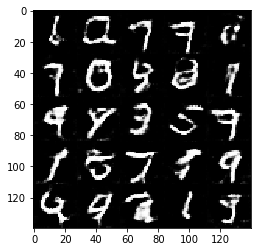

Epoch 1/2... Steps 810     Discriminator Loss: 1.3441... Generator Loss: 1.0713
Epoch 1/2... Steps 820     Discriminator Loss: 1.2426... Generator Loss: 0.8093
Epoch 1/2... Steps 830     Discriminator Loss: 1.2413... Generator Loss: 1.0442
Epoch 1/2... Steps 840     Discriminator Loss: 1.3057... Generator Loss: 0.7713
Epoch 1/2... Steps 850     Discriminator Loss: 1.2638... Generator Loss: 1.0552
Epoch 1/2... Steps 860     Discriminator Loss: 1.4178... Generator Loss: 0.5519
Epoch 1/2... Steps 870     Discriminator Loss: 1.1133... Generator Loss: 0.9885
Epoch 1/2... Steps 880     Discriminator Loss: 1.8807... Generator Loss: 0.3370
Epoch 1/2... Steps 890     Discriminator Loss: 1.2080... Generator Loss: 1.0238
Epoch 1/2... Steps 900     Discriminator Loss: 1.2943... Generator Loss: 0.7272


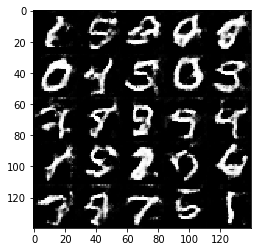

Epoch 1/2... Steps 910     Discriminator Loss: 1.4100... Generator Loss: 0.5385
Epoch 1/2... Steps 920     Discriminator Loss: 1.1428... Generator Loss: 1.0921
Epoch 1/2... Steps 930     Discriminator Loss: 1.2588... Generator Loss: 0.7793
Epoch 1/2... Steps 940     Discriminator Loss: 1.1785... Generator Loss: 0.9575
Epoch 1/2... Steps 950     Discriminator Loss: 1.4009... Generator Loss: 1.7290
Epoch 1/2... Steps 960     Discriminator Loss: 1.3310... Generator Loss: 0.8893
Epoch 1/2... Steps 970     Discriminator Loss: 1.2752... Generator Loss: 0.8970
Epoch 1/2... Steps 980     Discriminator Loss: 1.2875... Generator Loss: 0.8128
Epoch 1/2... Steps 990     Discriminator Loss: 1.1974... Generator Loss: 1.2881
Epoch 1/2... Steps 1000     Discriminator Loss: 1.5129... Generator Loss: 1.6268


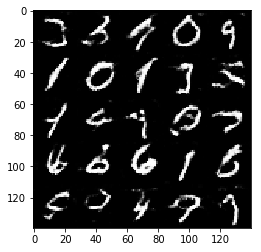

Epoch 1/2... Steps 1010     Discriminator Loss: 1.2617... Generator Loss: 0.9206
Epoch 1/2... Steps 1020     Discriminator Loss: 1.0634... Generator Loss: 0.8931
Epoch 1/2... Steps 1030     Discriminator Loss: 1.1246... Generator Loss: 0.9780
Epoch 1/2... Steps 1040     Discriminator Loss: 1.1467... Generator Loss: 1.1098
Epoch 1/2... Steps 1050     Discriminator Loss: 1.0603... Generator Loss: 0.9318
Epoch 1/2... Steps 1060     Discriminator Loss: 1.7919... Generator Loss: 0.3267
Epoch 1/2... Steps 1070     Discriminator Loss: 1.1309... Generator Loss: 0.8891
Epoch 1/2... Steps 1080     Discriminator Loss: 1.2764... Generator Loss: 1.1473
Epoch 1/2... Steps 1090     Discriminator Loss: 1.1998... Generator Loss: 1.1794
Epoch 1/2... Steps 1100     Discriminator Loss: 1.0015... Generator Loss: 0.8992


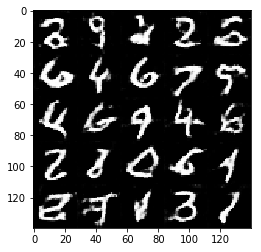

Epoch 1/2... Steps 1110     Discriminator Loss: 1.5642... Generator Loss: 0.4556
Epoch 1/2... Steps 1120     Discriminator Loss: 1.1366... Generator Loss: 1.2760
Epoch 1/2... Steps 1130     Discriminator Loss: 1.2948... Generator Loss: 0.6123
Epoch 1/2... Steps 1140     Discriminator Loss: 1.1747... Generator Loss: 0.7310
Epoch 1/2... Steps 1150     Discriminator Loss: 1.2075... Generator Loss: 0.8844
Epoch 1/2... Steps 1160     Discriminator Loss: 1.3393... Generator Loss: 0.6301
Epoch 1/2... Steps 1170     Discriminator Loss: 1.3420... Generator Loss: 0.6111
Epoch 1/2... Steps 1180     Discriminator Loss: 1.2094... Generator Loss: 1.3043
Epoch 1/2... Steps 1190     Discriminator Loss: 1.2966... Generator Loss: 0.6706
Epoch 1/2... Steps 1200     Discriminator Loss: 1.5400... Generator Loss: 1.8256


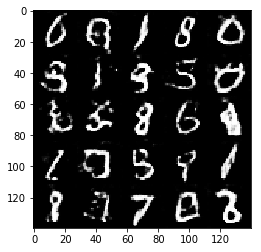

Epoch 1/2... Steps 1210     Discriminator Loss: 1.2528... Generator Loss: 0.6979
Epoch 1/2... Steps 1220     Discriminator Loss: 1.3098... Generator Loss: 1.7124
Epoch 1/2... Steps 1230     Discriminator Loss: 1.2673... Generator Loss: 0.6903
Epoch 1/2... Steps 1240     Discriminator Loss: 1.2943... Generator Loss: 0.6536
Epoch 1/2... Steps 1250     Discriminator Loss: 1.2931... Generator Loss: 0.5802
Epoch 1/2... Steps 1260     Discriminator Loss: 1.1916... Generator Loss: 1.1781
Epoch 1/2... Steps 1270     Discriminator Loss: 1.1713... Generator Loss: 1.2162
Epoch 1/2... Steps 1280     Discriminator Loss: 1.2126... Generator Loss: 0.6439
Epoch 1/2... Steps 1290     Discriminator Loss: 1.1902... Generator Loss: 1.2456
Epoch 1/2... Steps 1300     Discriminator Loss: 1.2181... Generator Loss: 1.1602


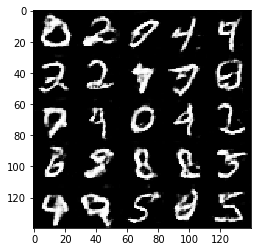

Epoch 1/2... Steps 1310     Discriminator Loss: 1.2541... Generator Loss: 0.6756
Epoch 1/2... Steps 1320     Discriminator Loss: 1.3059... Generator Loss: 0.6949
Epoch 1/2... Steps 1330     Discriminator Loss: 1.1786... Generator Loss: 1.4684
Epoch 1/2... Steps 1340     Discriminator Loss: 1.3511... Generator Loss: 0.5893
Epoch 1/2... Steps 1350     Discriminator Loss: 1.3199... Generator Loss: 1.4095
Epoch 1/2... Steps 1360     Discriminator Loss: 1.5502... Generator Loss: 2.1095
Epoch 1/2... Steps 1370     Discriminator Loss: 1.2676... Generator Loss: 0.9433
Epoch 1/2... Steps 1380     Discriminator Loss: 1.2089... Generator Loss: 0.6833
Epoch 1/2... Steps 1390     Discriminator Loss: 1.3372... Generator Loss: 0.5734
Epoch 1/2... Steps 1400     Discriminator Loss: 1.0173... Generator Loss: 0.9876


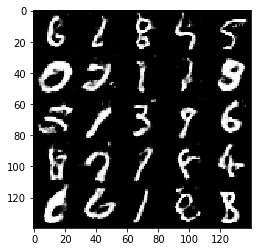

Epoch 1/2... Steps 1410     Discriminator Loss: 1.2083... Generator Loss: 0.7110
Epoch 1/2... Steps 1420     Discriminator Loss: 1.1630... Generator Loss: 0.6516
Epoch 1/2... Steps 1430     Discriminator Loss: 1.4693... Generator Loss: 0.5434
Epoch 1/2... Steps 1440     Discriminator Loss: 1.1265... Generator Loss: 0.9950
Epoch 1/2... Steps 1450     Discriminator Loss: 1.0608... Generator Loss: 1.1944
Epoch 1/2... Steps 1460     Discriminator Loss: 1.3628... Generator Loss: 0.5619
Epoch 1/2... Steps 1470     Discriminator Loss: 1.0740... Generator Loss: 0.9995
Epoch 1/2... Steps 1480     Discriminator Loss: 1.5894... Generator Loss: 0.3535
Epoch 1/2... Steps 1490     Discriminator Loss: 1.1097... Generator Loss: 0.7302
Epoch 1/2... Steps 1500     Discriminator Loss: 1.0770... Generator Loss: 0.8756


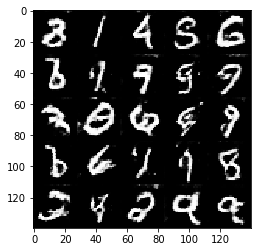

Epoch 1/2... Steps 1510     Discriminator Loss: 1.2870... Generator Loss: 1.7562
Epoch 1/2... Steps 1520     Discriminator Loss: 1.1438... Generator Loss: 1.9031
Epoch 1/2... Steps 1530     Discriminator Loss: 1.4528... Generator Loss: 0.6454
Epoch 1/2... Steps 1540     Discriminator Loss: 1.1773... Generator Loss: 0.8945
Epoch 1/2... Steps 1550     Discriminator Loss: 1.0443... Generator Loss: 1.1761
Epoch 1/2... Steps 1560     Discriminator Loss: 0.9883... Generator Loss: 1.0984
Epoch 1/2... Steps 1570     Discriminator Loss: 1.7060... Generator Loss: 0.3458
Epoch 1/2... Steps 1580     Discriminator Loss: 1.6974... Generator Loss: 0.2869
Epoch 1/2... Steps 1590     Discriminator Loss: 1.2487... Generator Loss: 0.9357
Epoch 1/2... Steps 1600     Discriminator Loss: 1.2485... Generator Loss: 0.7089


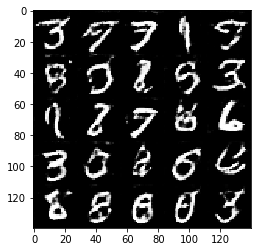

Epoch 1/2... Steps 1610     Discriminator Loss: 1.2623... Generator Loss: 1.4508
Epoch 1/2... Steps 1620     Discriminator Loss: 1.2699... Generator Loss: 0.6884
Epoch 1/2... Steps 1630     Discriminator Loss: 1.1548... Generator Loss: 0.8418
Epoch 1/2... Steps 1640     Discriminator Loss: 1.0319... Generator Loss: 1.2058
Epoch 1/2... Steps 1650     Discriminator Loss: 1.2137... Generator Loss: 0.6519
Epoch 1/2... Steps 1660     Discriminator Loss: 1.5699... Generator Loss: 0.4368
Epoch 1/2... Steps 1670     Discriminator Loss: 1.0984... Generator Loss: 0.9711
Epoch 1/2... Steps 1680     Discriminator Loss: 1.0848... Generator Loss: 0.9636
Epoch 1/2... Steps 1690     Discriminator Loss: 0.8892... Generator Loss: 1.2254
Epoch 1/2... Steps 1700     Discriminator Loss: 1.2577... Generator Loss: 0.6846


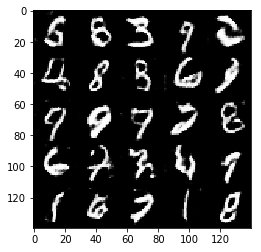

Epoch 1/2... Steps 1710     Discriminator Loss: 1.3078... Generator Loss: 1.3259
Epoch 1/2... Steps 1720     Discriminator Loss: 1.3051... Generator Loss: 0.7181
Epoch 1/2... Steps 1730     Discriminator Loss: 1.1783... Generator Loss: 1.7566
Epoch 1/2... Steps 1740     Discriminator Loss: 1.0514... Generator Loss: 0.9617
Epoch 1/2... Steps 1750     Discriminator Loss: 1.6483... Generator Loss: 2.3776
Epoch 1/2... Steps 1760     Discriminator Loss: 1.0958... Generator Loss: 1.6874
Epoch 1/2... Steps 1770     Discriminator Loss: 1.1105... Generator Loss: 1.0863
Epoch 1/2... Steps 1780     Discriminator Loss: 1.4156... Generator Loss: 0.5456
Epoch 1/2... Steps 1790     Discriminator Loss: 1.7088... Generator Loss: 2.0030
Epoch 1/2... Steps 1800     Discriminator Loss: 1.2349... Generator Loss: 1.1100


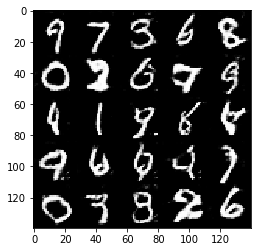

Epoch 1/2... Steps 1810     Discriminator Loss: 1.0475... Generator Loss: 0.8264
Epoch 1/2... Steps 1820     Discriminator Loss: 1.7234... Generator Loss: 0.4195
Epoch 1/2... Steps 1830     Discriminator Loss: 1.0503... Generator Loss: 1.8893
Epoch 1/2... Steps 1840     Discriminator Loss: 1.3918... Generator Loss: 1.7223
Epoch 1/2... Steps 1850     Discriminator Loss: 1.4330... Generator Loss: 0.5296
Epoch 1/2... Steps 1860     Discriminator Loss: 1.0084... Generator Loss: 1.3444
Epoch 1/2... Steps 1870     Discriminator Loss: 0.9209... Generator Loss: 1.1244
Epoch 2/2... Steps 1880     Discriminator Loss: 1.1503... Generator Loss: 0.8055
Epoch 2/2... Steps 1890     Discriminator Loss: 1.1046... Generator Loss: 1.5369
Epoch 2/2... Steps 1900     Discriminator Loss: 1.0994... Generator Loss: 0.7973


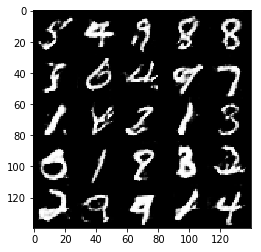

Epoch 2/2... Steps 1910     Discriminator Loss: 1.3528... Generator Loss: 0.4929
Epoch 2/2... Steps 1920     Discriminator Loss: 0.9352... Generator Loss: 1.7193
Epoch 2/2... Steps 1930     Discriminator Loss: 1.3095... Generator Loss: 0.5656
Epoch 2/2... Steps 1940     Discriminator Loss: 1.1159... Generator Loss: 0.6145
Epoch 2/2... Steps 1950     Discriminator Loss: 1.0784... Generator Loss: 1.0653
Epoch 2/2... Steps 1960     Discriminator Loss: 1.1801... Generator Loss: 0.8920
Epoch 2/2... Steps 1970     Discriminator Loss: 1.4435... Generator Loss: 0.4207
Epoch 2/2... Steps 1980     Discriminator Loss: 1.1190... Generator Loss: 0.7396
Epoch 2/2... Steps 1990     Discriminator Loss: 1.4676... Generator Loss: 0.5455
Epoch 2/2... Steps 2000     Discriminator Loss: 1.3582... Generator Loss: 0.5426


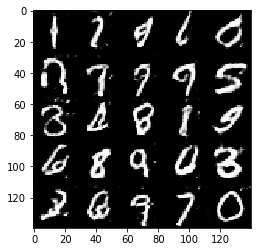

Epoch 2/2... Steps 2010     Discriminator Loss: 1.4515... Generator Loss: 0.4999
Epoch 2/2... Steps 2020     Discriminator Loss: 1.1761... Generator Loss: 2.1513
Epoch 2/2... Steps 2030     Discriminator Loss: 0.9163... Generator Loss: 1.8188
Epoch 2/2... Steps 2040     Discriminator Loss: 0.9358... Generator Loss: 1.2488
Epoch 2/2... Steps 2050     Discriminator Loss: 1.2416... Generator Loss: 0.7121
Epoch 2/2... Steps 2060     Discriminator Loss: 1.1302... Generator Loss: 1.2787
Epoch 2/2... Steps 2070     Discriminator Loss: 1.2334... Generator Loss: 1.4844
Epoch 2/2... Steps 2080     Discriminator Loss: 1.1251... Generator Loss: 1.7501
Epoch 2/2... Steps 2090     Discriminator Loss: 1.2755... Generator Loss: 0.6240
Epoch 2/2... Steps 2100     Discriminator Loss: 0.8994... Generator Loss: 1.3977


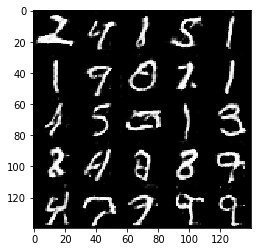

Epoch 2/2... Steps 2110     Discriminator Loss: 1.0302... Generator Loss: 1.1915
Epoch 2/2... Steps 2120     Discriminator Loss: 1.6328... Generator Loss: 0.4975
Epoch 2/2... Steps 2130     Discriminator Loss: 1.1494... Generator Loss: 1.1375
Epoch 2/2... Steps 2140     Discriminator Loss: 0.9262... Generator Loss: 1.1828
Epoch 2/2... Steps 2150     Discriminator Loss: 0.9756... Generator Loss: 1.0132
Epoch 2/2... Steps 2160     Discriminator Loss: 1.5210... Generator Loss: 1.9431
Epoch 2/2... Steps 2170     Discriminator Loss: 1.1818... Generator Loss: 0.7970
Epoch 2/2... Steps 2180     Discriminator Loss: 0.9531... Generator Loss: 1.8890
Epoch 2/2... Steps 2190     Discriminator Loss: 1.0471... Generator Loss: 0.9698
Epoch 2/2... Steps 2200     Discriminator Loss: 1.3153... Generator Loss: 1.8596


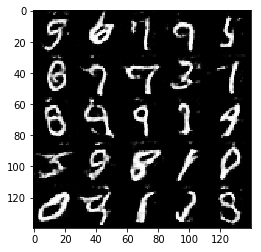

Epoch 2/2... Steps 2210     Discriminator Loss: 1.5065... Generator Loss: 0.4099
Epoch 2/2... Steps 2220     Discriminator Loss: 0.9515... Generator Loss: 1.3972
Epoch 2/2... Steps 2230     Discriminator Loss: 1.3299... Generator Loss: 0.6467
Epoch 2/2... Steps 2240     Discriminator Loss: 1.0148... Generator Loss: 1.0356
Epoch 2/2... Steps 2250     Discriminator Loss: 1.0432... Generator Loss: 1.8621
Epoch 2/2... Steps 2260     Discriminator Loss: 1.1407... Generator Loss: 0.9344
Epoch 2/2... Steps 2270     Discriminator Loss: 0.9627... Generator Loss: 1.2436
Epoch 2/2... Steps 2280     Discriminator Loss: 0.9290... Generator Loss: 1.2172
Epoch 2/2... Steps 2290     Discriminator Loss: 1.3598... Generator Loss: 1.1059
Epoch 2/2... Steps 2300     Discriminator Loss: 1.5175... Generator Loss: 0.3981


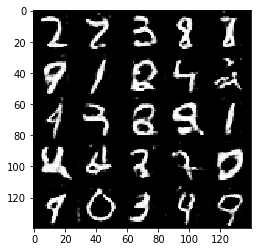

Epoch 2/2... Steps 2310     Discriminator Loss: 1.5882... Generator Loss: 0.4013
Epoch 2/2... Steps 2320     Discriminator Loss: 1.2331... Generator Loss: 0.7460
Epoch 2/2... Steps 2330     Discriminator Loss: 0.9764... Generator Loss: 1.2481
Epoch 2/2... Steps 2340     Discriminator Loss: 1.3300... Generator Loss: 0.5447
Epoch 2/2... Steps 2350     Discriminator Loss: 1.1254... Generator Loss: 0.8417
Epoch 2/2... Steps 2360     Discriminator Loss: 1.1041... Generator Loss: 1.2039
Epoch 2/2... Steps 2370     Discriminator Loss: 1.0946... Generator Loss: 1.1323
Epoch 2/2... Steps 2380     Discriminator Loss: 0.9737... Generator Loss: 0.9064
Epoch 2/2... Steps 2390     Discriminator Loss: 1.1396... Generator Loss: 1.0077
Epoch 2/2... Steps 2400     Discriminator Loss: 1.7076... Generator Loss: 0.3599


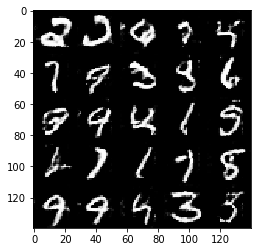

Epoch 2/2... Steps 2410     Discriminator Loss: 1.1024... Generator Loss: 1.7631
Epoch 2/2... Steps 2420     Discriminator Loss: 0.8498... Generator Loss: 1.2686
Epoch 2/2... Steps 2430     Discriminator Loss: 1.2441... Generator Loss: 1.2896
Epoch 2/2... Steps 2440     Discriminator Loss: 1.3730... Generator Loss: 0.6213
Epoch 2/2... Steps 2450     Discriminator Loss: 0.9660... Generator Loss: 1.4784
Epoch 2/2... Steps 2460     Discriminator Loss: 1.3547... Generator Loss: 0.5107
Epoch 2/2... Steps 2470     Discriminator Loss: 1.5619... Generator Loss: 0.4607
Epoch 2/2... Steps 2480     Discriminator Loss: 1.0060... Generator Loss: 1.0115
Epoch 2/2... Steps 2490     Discriminator Loss: 1.3724... Generator Loss: 0.5027
Epoch 2/2... Steps 2500     Discriminator Loss: 1.2900... Generator Loss: 2.1265


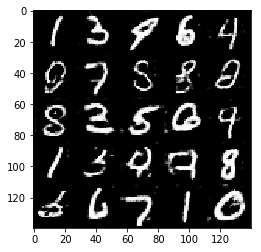

Epoch 2/2... Steps 2510     Discriminator Loss: 1.1025... Generator Loss: 0.7596
Epoch 2/2... Steps 2520     Discriminator Loss: 0.9672... Generator Loss: 1.5448
Epoch 2/2... Steps 2530     Discriminator Loss: 1.0502... Generator Loss: 0.6611
Epoch 2/2... Steps 2540     Discriminator Loss: 1.1688... Generator Loss: 0.7667
Epoch 2/2... Steps 2550     Discriminator Loss: 1.1895... Generator Loss: 1.5402
Epoch 2/2... Steps 2560     Discriminator Loss: 1.8187... Generator Loss: 0.4506
Epoch 2/2... Steps 2570     Discriminator Loss: 1.2592... Generator Loss: 0.7867
Epoch 2/2... Steps 2580     Discriminator Loss: 1.2253... Generator Loss: 0.7223
Epoch 2/2... Steps 2590     Discriminator Loss: 0.9782... Generator Loss: 0.9525
Epoch 2/2... Steps 2600     Discriminator Loss: 1.2582... Generator Loss: 0.7705


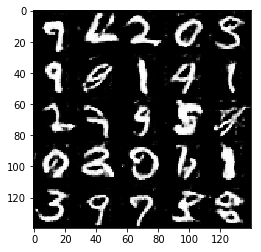

Epoch 2/2... Steps 2610     Discriminator Loss: 1.0030... Generator Loss: 1.0878
Epoch 2/2... Steps 2620     Discriminator Loss: 0.8975... Generator Loss: 1.9895
Epoch 2/2... Steps 2630     Discriminator Loss: 0.9386... Generator Loss: 0.9266
Epoch 2/2... Steps 2640     Discriminator Loss: 1.4950... Generator Loss: 0.6260
Epoch 2/2... Steps 2650     Discriminator Loss: 0.8152... Generator Loss: 1.8218
Epoch 2/2... Steps 2660     Discriminator Loss: 1.3744... Generator Loss: 0.5969
Epoch 2/2... Steps 2670     Discriminator Loss: 1.6928... Generator Loss: 2.7875
Epoch 2/2... Steps 2680     Discriminator Loss: 1.2922... Generator Loss: 0.4513
Epoch 2/2... Steps 2690     Discriminator Loss: 0.9839... Generator Loss: 0.9026
Epoch 2/2... Steps 2700     Discriminator Loss: 0.7991... Generator Loss: 1.4300


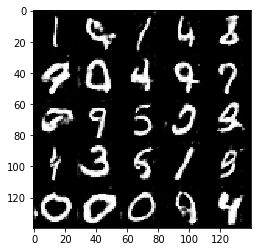

Epoch 2/2... Steps 2710     Discriminator Loss: 1.4774... Generator Loss: 1.6747
Epoch 2/2... Steps 2720     Discriminator Loss: 1.2134... Generator Loss: 0.7225
Epoch 2/2... Steps 2730     Discriminator Loss: 0.9509... Generator Loss: 1.0447
Epoch 2/2... Steps 2740     Discriminator Loss: 2.0462... Generator Loss: 3.1082
Epoch 2/2... Steps 2750     Discriminator Loss: 0.9280... Generator Loss: 1.0713
Epoch 2/2... Steps 2760     Discriminator Loss: 1.1245... Generator Loss: 0.8673
Epoch 2/2... Steps 2770     Discriminator Loss: 1.1478... Generator Loss: 0.9087
Epoch 2/2... Steps 2780     Discriminator Loss: 0.9466... Generator Loss: 0.9172
Epoch 2/2... Steps 2790     Discriminator Loss: 0.9845... Generator Loss: 1.2676
Epoch 2/2... Steps 2800     Discriminator Loss: 1.2364... Generator Loss: 1.0315


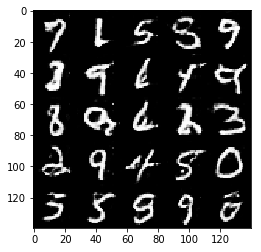

Epoch 2/2... Steps 2810     Discriminator Loss: 1.2215... Generator Loss: 1.3016
Epoch 2/2... Steps 2820     Discriminator Loss: 0.9069... Generator Loss: 2.3044
Epoch 2/2... Steps 2830     Discriminator Loss: 1.4708... Generator Loss: 0.4688
Epoch 2/2... Steps 2840     Discriminator Loss: 1.3317... Generator Loss: 2.1196
Epoch 2/2... Steps 2850     Discriminator Loss: 1.0284... Generator Loss: 2.5204
Epoch 2/2... Steps 2860     Discriminator Loss: 0.9018... Generator Loss: 1.0079
Epoch 2/2... Steps 2870     Discriminator Loss: 1.0120... Generator Loss: 0.9664
Epoch 2/2... Steps 2880     Discriminator Loss: 1.3576... Generator Loss: 0.8963
Epoch 2/2... Steps 2890     Discriminator Loss: 0.9699... Generator Loss: 1.1991
Epoch 2/2... Steps 2900     Discriminator Loss: 1.7500... Generator Loss: 0.3963


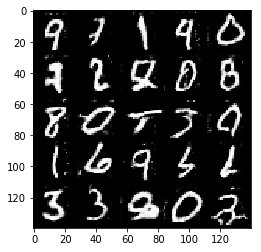

Epoch 2/2... Steps 2910     Discriminator Loss: 1.4315... Generator Loss: 0.4908
Epoch 2/2... Steps 2920     Discriminator Loss: 1.0988... Generator Loss: 1.2319
Epoch 2/2... Steps 2930     Discriminator Loss: 1.2873... Generator Loss: 1.8693
Epoch 2/2... Steps 2940     Discriminator Loss: 1.2416... Generator Loss: 0.7557
Epoch 2/2... Steps 2950     Discriminator Loss: 0.8170... Generator Loss: 1.5672
Epoch 2/2... Steps 2960     Discriminator Loss: 0.8906... Generator Loss: 1.2210
Epoch 2/2... Steps 2970     Discriminator Loss: 1.1217... Generator Loss: 1.3493
Epoch 2/2... Steps 2980     Discriminator Loss: 0.7649... Generator Loss: 1.3743
Epoch 2/2... Steps 2990     Discriminator Loss: 1.2224... Generator Loss: 0.7385
Epoch 2/2... Steps 3000     Discriminator Loss: 0.8476... Generator Loss: 1.5563


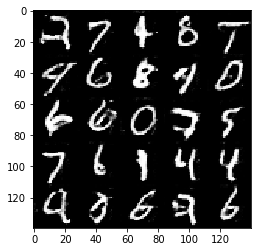

Epoch 2/2... Steps 3010     Discriminator Loss: 0.9095... Generator Loss: 1.1381
Epoch 2/2... Steps 3020     Discriminator Loss: 0.9085... Generator Loss: 1.9475
Epoch 2/2... Steps 3030     Discriminator Loss: 1.0983... Generator Loss: 0.8772
Epoch 2/2... Steps 3040     Discriminator Loss: 0.9243... Generator Loss: 1.3298
Epoch 2/2... Steps 3050     Discriminator Loss: 1.5114... Generator Loss: 1.5632
Epoch 2/2... Steps 3060     Discriminator Loss: 0.9076... Generator Loss: 1.1220
Epoch 2/2... Steps 3070     Discriminator Loss: 1.1721... Generator Loss: 1.5553
Epoch 2/2... Steps 3080     Discriminator Loss: 1.0723... Generator Loss: 0.6752
Epoch 2/2... Steps 3090     Discriminator Loss: 0.9316... Generator Loss: 1.0460
Epoch 2/2... Steps 3100     Discriminator Loss: 1.0253... Generator Loss: 0.8961


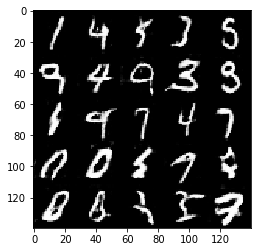

Epoch 2/2... Steps 3110     Discriminator Loss: 0.8224... Generator Loss: 1.0167
Epoch 2/2... Steps 3120     Discriminator Loss: 0.7921... Generator Loss: 1.4281
Epoch 2/2... Steps 3130     Discriminator Loss: 0.8162... Generator Loss: 1.7801
Epoch 2/2... Steps 3140     Discriminator Loss: 0.9732... Generator Loss: 1.3432
Epoch 2/2... Steps 3150     Discriminator Loss: 1.0546... Generator Loss: 1.7546
Epoch 2/2... Steps 3160     Discriminator Loss: 1.0560... Generator Loss: 1.1046
Epoch 2/2... Steps 3170     Discriminator Loss: 1.1532... Generator Loss: 0.8326
Epoch 2/2... Steps 3180     Discriminator Loss: 1.1360... Generator Loss: 1.0009
Epoch 2/2... Steps 3190     Discriminator Loss: 0.9644... Generator Loss: 1.6728
Epoch 2/2... Steps 3200     Discriminator Loss: 0.9937... Generator Loss: 1.6630


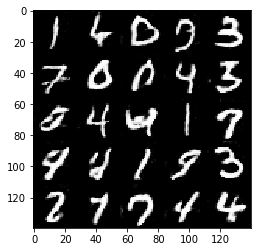

Epoch 2/2... Steps 3210     Discriminator Loss: 0.8373... Generator Loss: 1.7348
Epoch 2/2... Steps 3220     Discriminator Loss: 0.8883... Generator Loss: 2.0018
Epoch 2/2... Steps 3230     Discriminator Loss: 1.0522... Generator Loss: 0.8863
Epoch 2/2... Steps 3240     Discriminator Loss: 0.9373... Generator Loss: 1.2275
Epoch 2/2... Steps 3250     Discriminator Loss: 1.2865... Generator Loss: 0.7553
Epoch 2/2... Steps 3260     Discriminator Loss: 1.8882... Generator Loss: 0.3619
Epoch 2/2... Steps 3270     Discriminator Loss: 0.8986... Generator Loss: 1.0588
Epoch 2/2... Steps 3280     Discriminator Loss: 1.5978... Generator Loss: 2.4173
Epoch 2/2... Steps 3290     Discriminator Loss: 1.0524... Generator Loss: 1.2720
Epoch 2/2... Steps 3300     Discriminator Loss: 0.8621... Generator Loss: 1.6962


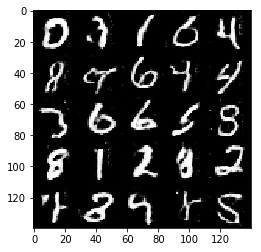

Epoch 2/2... Steps 3310     Discriminator Loss: 0.9234... Generator Loss: 1.1579
Epoch 2/2... Steps 3320     Discriminator Loss: 1.2405... Generator Loss: 0.8284
Epoch 2/2... Steps 3330     Discriminator Loss: 0.7328... Generator Loss: 2.2354
Epoch 2/2... Steps 3340     Discriminator Loss: 1.0207... Generator Loss: 1.1182
Epoch 2/2... Steps 3350     Discriminator Loss: 0.8928... Generator Loss: 1.4327
Epoch 2/2... Steps 3360     Discriminator Loss: 1.3670... Generator Loss: 0.5831
Epoch 2/2... Steps 3370     Discriminator Loss: 0.8282... Generator Loss: 1.9595
Epoch 2/2... Steps 3380     Discriminator Loss: 0.9278... Generator Loss: 1.0665
Epoch 2/2... Steps 3390     Discriminator Loss: 1.0779... Generator Loss: 0.8654
Epoch 2/2... Steps 3400     Discriminator Loss: 0.8912... Generator Loss: 0.9448


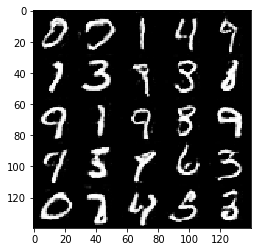

Epoch 2/2... Steps 3410     Discriminator Loss: 0.9981... Generator Loss: 1.1453
Epoch 2/2... Steps 3420     Discriminator Loss: 0.9481... Generator Loss: 1.1873
Epoch 2/2... Steps 3430     Discriminator Loss: 1.0317... Generator Loss: 1.1609
Epoch 2/2... Steps 3440     Discriminator Loss: 1.4962... Generator Loss: 2.7909
Epoch 2/2... Steps 3450     Discriminator Loss: 1.0396... Generator Loss: 0.8331
Epoch 2/2... Steps 3460     Discriminator Loss: 1.0741... Generator Loss: 1.6546
Epoch 2/2... Steps 3470     Discriminator Loss: 0.9140... Generator Loss: 1.1920
Epoch 2/2... Steps 3480     Discriminator Loss: 1.0574... Generator Loss: 0.9013
Epoch 2/2... Steps 3490     Discriminator Loss: 0.6303... Generator Loss: 1.5378
Epoch 2/2... Steps 3500     Discriminator Loss: 0.6729... Generator Loss: 1.7245


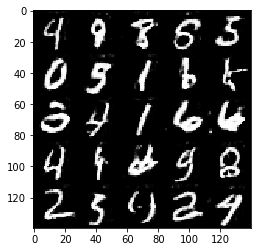

Epoch 2/2... Steps 3510     Discriminator Loss: 2.0265... Generator Loss: 0.3388
Epoch 2/2... Steps 3520     Discriminator Loss: 0.9665... Generator Loss: 0.9363
Epoch 2/2... Steps 3530     Discriminator Loss: 1.1911... Generator Loss: 2.4654
Epoch 2/2... Steps 3540     Discriminator Loss: 1.5893... Generator Loss: 3.0224
Epoch 2/2... Steps 3550     Discriminator Loss: 0.8600... Generator Loss: 1.1790
Epoch 2/2... Steps 3560     Discriminator Loss: 0.8062... Generator Loss: 1.1308
Epoch 2/2... Steps 3570     Discriminator Loss: 1.3649... Generator Loss: 0.5609
Epoch 2/2... Steps 3580     Discriminator Loss: 1.0931... Generator Loss: 1.4123
Epoch 2/2... Steps 3590     Discriminator Loss: 0.8897... Generator Loss: 1.3424
Epoch 2/2... Steps 3600     Discriminator Loss: 0.8609... Generator Loss: 1.4590


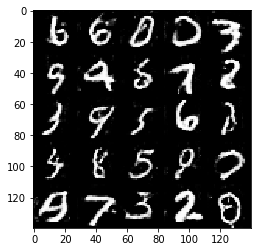

Epoch 2/2... Steps 3610     Discriminator Loss: 0.7466... Generator Loss: 1.5117
Epoch 2/2... Steps 3620     Discriminator Loss: 0.9718... Generator Loss: 1.5332
Epoch 2/2... Steps 3630     Discriminator Loss: 2.1125... Generator Loss: 3.8286
Epoch 2/2... Steps 3640     Discriminator Loss: 0.9013... Generator Loss: 1.0684
Epoch 2/2... Steps 3650     Discriminator Loss: 1.1264... Generator Loss: 0.9321
Epoch 2/2... Steps 3660     Discriminator Loss: 0.8634... Generator Loss: 1.3788
Epoch 2/2... Steps 3670     Discriminator Loss: 1.1404... Generator Loss: 0.8616
Epoch 2/2... Steps 3680     Discriminator Loss: 1.0546... Generator Loss: 2.0749
Epoch 2/2... Steps 3690     Discriminator Loss: 0.8065... Generator Loss: 1.5643
Epoch 2/2... Steps 3700     Discriminator Loss: 0.9865... Generator Loss: 1.7172


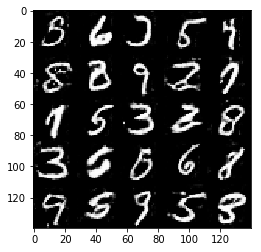

Epoch 2/2... Steps 3710     Discriminator Loss: 1.0865... Generator Loss: 1.9297
Epoch 2/2... Steps 3720     Discriminator Loss: 0.9837... Generator Loss: 0.9106
Epoch 2/2... Steps 3730     Discriminator Loss: 0.9314... Generator Loss: 1.4382
Epoch 2/2... Steps 3740     Discriminator Loss: 1.1712... Generator Loss: 1.3430
Epoch 2/2... Steps 3750     Discriminator Loss: 0.8628... Generator Loss: 2.1095


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Steps 10     Discriminator Loss: 0.8802... Generator Loss: 3.1544
Epoch 1/1... Steps 20     Discriminator Loss: 1.7041... Generator Loss: 0.6312
Epoch 1/1... Steps 30     Discriminator Loss: 2.4849... Generator Loss: 0.1815
Epoch 1/1... Steps 40     Discriminator Loss: 1.6595... Generator Loss: 0.4687
Epoch 1/1... Steps 50     Discriminator Loss: 1.6773... Generator Loss: 0.4918
Epoch 1/1... Steps 60     Discriminator Loss: 1.3090... Generator Loss: 0.8021
Epoch 1/1... Steps 70     Discriminator Loss: 1.2119... Generator Loss: 0.9432
Epoch 1/1... Steps 80     Discriminator Loss: 1.6273... Generator Loss: 0.7511
Epoch 1/1... Steps 90     Discriminator Loss: 1.5587... Generator Loss: 0.5680
Epoch 1/1... Steps 100     Discriminator Loss: 1.4675... Generator Loss: 1.4203


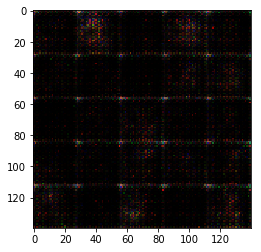

Epoch 1/1... Steps 110     Discriminator Loss: 1.2672... Generator Loss: 0.8381
Epoch 1/1... Steps 120     Discriminator Loss: 2.1246... Generator Loss: 0.2102
Epoch 1/1... Steps 130     Discriminator Loss: 1.6808... Generator Loss: 1.2932
Epoch 1/1... Steps 140     Discriminator Loss: 1.3086... Generator Loss: 1.1052
Epoch 1/1... Steps 150     Discriminator Loss: 1.2674... Generator Loss: 1.1619
Epoch 1/1... Steps 160     Discriminator Loss: 1.2836... Generator Loss: 0.8155
Epoch 1/1... Steps 170     Discriminator Loss: 1.2885... Generator Loss: 0.7024
Epoch 1/1... Steps 180     Discriminator Loss: 1.6596... Generator Loss: 1.8629
Epoch 1/1... Steps 190     Discriminator Loss: 1.7611... Generator Loss: 0.3535
Epoch 1/1... Steps 200     Discriminator Loss: 1.2709... Generator Loss: 0.8455


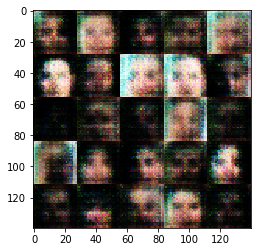

Epoch 1/1... Steps 210     Discriminator Loss: 1.5384... Generator Loss: 1.1616
Epoch 1/1... Steps 220     Discriminator Loss: 1.2447... Generator Loss: 1.0500
Epoch 1/1... Steps 230     Discriminator Loss: 1.8450... Generator Loss: 0.3670
Epoch 1/1... Steps 240     Discriminator Loss: 1.2802... Generator Loss: 0.5772
Epoch 1/1... Steps 250     Discriminator Loss: 1.3620... Generator Loss: 0.7437
Epoch 1/1... Steps 260     Discriminator Loss: 1.5100... Generator Loss: 0.4732
Epoch 1/1... Steps 270     Discriminator Loss: 1.2419... Generator Loss: 0.8357
Epoch 1/1... Steps 280     Discriminator Loss: 1.4454... Generator Loss: 0.5954
Epoch 1/1... Steps 290     Discriminator Loss: 1.1807... Generator Loss: 0.8067
Epoch 1/1... Steps 300     Discriminator Loss: 1.6317... Generator Loss: 2.2576


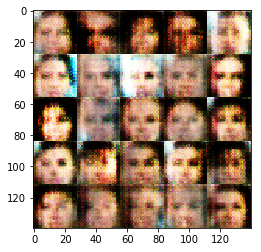

Epoch 1/1... Steps 310     Discriminator Loss: 1.7738... Generator Loss: 0.3678
Epoch 1/1... Steps 320     Discriminator Loss: 1.2688... Generator Loss: 0.9310
Epoch 1/1... Steps 330     Discriminator Loss: 1.7967... Generator Loss: 2.4108
Epoch 1/1... Steps 340     Discriminator Loss: 1.3298... Generator Loss: 1.2083
Epoch 1/1... Steps 350     Discriminator Loss: 1.3322... Generator Loss: 0.8262
Epoch 1/1... Steps 360     Discriminator Loss: 1.3024... Generator Loss: 1.0938
Epoch 1/1... Steps 370     Discriminator Loss: 1.4301... Generator Loss: 0.5005
Epoch 1/1... Steps 380     Discriminator Loss: 1.4998... Generator Loss: 1.0030
Epoch 1/1... Steps 390     Discriminator Loss: 1.2504... Generator Loss: 0.7834
Epoch 1/1... Steps 400     Discriminator Loss: 0.7605... Generator Loss: 1.2999


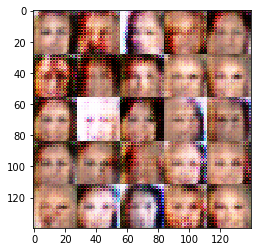

Epoch 1/1... Steps 410     Discriminator Loss: 1.0175... Generator Loss: 0.9846
Epoch 1/1... Steps 420     Discriminator Loss: 1.0303... Generator Loss: 1.3670
Epoch 1/1... Steps 430     Discriminator Loss: 0.8677... Generator Loss: 1.4171
Epoch 1/1... Steps 440     Discriminator Loss: 2.2611... Generator Loss: 0.2461
Epoch 1/1... Steps 450     Discriminator Loss: 1.3887... Generator Loss: 1.1810
Epoch 1/1... Steps 460     Discriminator Loss: 0.9981... Generator Loss: 1.5403
Epoch 1/1... Steps 470     Discriminator Loss: 2.6299... Generator Loss: 2.7516
Epoch 1/1... Steps 480     Discriminator Loss: 1.3514... Generator Loss: 0.5276
Epoch 1/1... Steps 490     Discriminator Loss: 0.6449... Generator Loss: 2.7951
Epoch 1/1... Steps 500     Discriminator Loss: 1.5970... Generator Loss: 0.5234


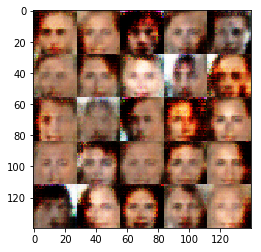

Epoch 1/1... Steps 510     Discriminator Loss: 1.4760... Generator Loss: 0.7809
Epoch 1/1... Steps 520     Discriminator Loss: 1.1841... Generator Loss: 1.1647
Epoch 1/1... Steps 530     Discriminator Loss: 1.4550... Generator Loss: 1.3521
Epoch 1/1... Steps 540     Discriminator Loss: 1.3193... Generator Loss: 0.7620
Epoch 1/1... Steps 550     Discriminator Loss: 1.2004... Generator Loss: 0.6453
Epoch 1/1... Steps 560     Discriminator Loss: 1.2770... Generator Loss: 0.9956
Epoch 1/1... Steps 570     Discriminator Loss: 1.0404... Generator Loss: 0.8648
Epoch 1/1... Steps 580     Discriminator Loss: 1.3817... Generator Loss: 1.2747
Epoch 1/1... Steps 590     Discriminator Loss: 0.9069... Generator Loss: 2.4918
Epoch 1/1... Steps 600     Discriminator Loss: 1.5415... Generator Loss: 0.6540


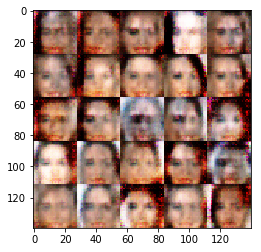

Epoch 1/1... Steps 610     Discriminator Loss: 1.4314... Generator Loss: 0.5633
Epoch 1/1... Steps 620     Discriminator Loss: 1.3180... Generator Loss: 0.9440
Epoch 1/1... Steps 630     Discriminator Loss: 0.9413... Generator Loss: 0.8582
Epoch 1/1... Steps 640     Discriminator Loss: 1.5243... Generator Loss: 0.5698
Epoch 1/1... Steps 650     Discriminator Loss: 1.2743... Generator Loss: 0.6492
Epoch 1/1... Steps 660     Discriminator Loss: 1.2806... Generator Loss: 0.9742
Epoch 1/1... Steps 670     Discriminator Loss: 1.4182... Generator Loss: 1.0646
Epoch 1/1... Steps 680     Discriminator Loss: 1.2823... Generator Loss: 0.7504
Epoch 1/1... Steps 690     Discriminator Loss: 1.1663... Generator Loss: 0.7037
Epoch 1/1... Steps 700     Discriminator Loss: 1.1824... Generator Loss: 1.0520


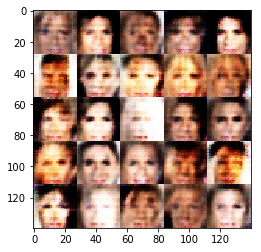

Epoch 1/1... Steps 710     Discriminator Loss: 1.2719... Generator Loss: 3.0512
Epoch 1/1... Steps 720     Discriminator Loss: 1.1911... Generator Loss: 0.8240
Epoch 1/1... Steps 730     Discriminator Loss: 1.5010... Generator Loss: 0.6585
Epoch 1/1... Steps 740     Discriminator Loss: 1.6840... Generator Loss: 0.3935
Epoch 1/1... Steps 750     Discriminator Loss: 1.5763... Generator Loss: 0.3774
Epoch 1/1... Steps 760     Discriminator Loss: 1.3062... Generator Loss: 1.6737
Epoch 1/1... Steps 770     Discriminator Loss: 1.4400... Generator Loss: 1.6084
Epoch 1/1... Steps 780     Discriminator Loss: 0.9706... Generator Loss: 0.9731
Epoch 1/1... Steps 790     Discriminator Loss: 2.9799... Generator Loss: 0.0972
Epoch 1/1... Steps 800     Discriminator Loss: 1.3655... Generator Loss: 0.7812


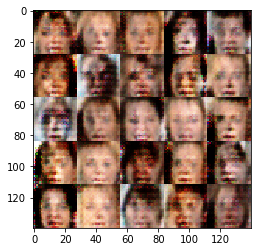

Epoch 1/1... Steps 810     Discriminator Loss: 1.3470... Generator Loss: 0.8233
Epoch 1/1... Steps 820     Discriminator Loss: 1.4574... Generator Loss: 0.6709
Epoch 1/1... Steps 830     Discriminator Loss: 1.0094... Generator Loss: 1.1954
Epoch 1/1... Steps 840     Discriminator Loss: 1.1213... Generator Loss: 1.9881
Epoch 1/1... Steps 850     Discriminator Loss: 1.1744... Generator Loss: 0.8640
Epoch 1/1... Steps 860     Discriminator Loss: 1.3791... Generator Loss: 0.8785
Epoch 1/1... Steps 870     Discriminator Loss: 1.3798... Generator Loss: 0.6932
Epoch 1/1... Steps 880     Discriminator Loss: 1.5936... Generator Loss: 0.3486
Epoch 1/1... Steps 890     Discriminator Loss: 1.7587... Generator Loss: 0.3490
Epoch 1/1... Steps 900     Discriminator Loss: 1.1617... Generator Loss: 0.9769


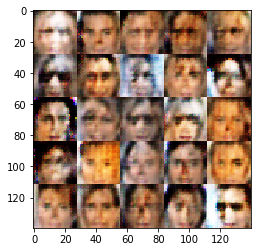

Epoch 1/1... Steps 910     Discriminator Loss: 1.3517... Generator Loss: 0.8961
Epoch 1/1... Steps 920     Discriminator Loss: 1.3362... Generator Loss: 0.5963
Epoch 1/1... Steps 930     Discriminator Loss: 1.1048... Generator Loss: 1.1884
Epoch 1/1... Steps 940     Discriminator Loss: 1.3882... Generator Loss: 0.7437
Epoch 1/1... Steps 950     Discriminator Loss: 1.2687... Generator Loss: 0.8770
Epoch 1/1... Steps 960     Discriminator Loss: 1.1280... Generator Loss: 0.9174
Epoch 1/1... Steps 970     Discriminator Loss: 1.4648... Generator Loss: 0.4712
Epoch 1/1... Steps 980     Discriminator Loss: 1.1671... Generator Loss: 0.8770
Epoch 1/1... Steps 990     Discriminator Loss: 1.4214... Generator Loss: 0.5580
Epoch 1/1... Steps 1000     Discriminator Loss: 1.3232... Generator Loss: 0.9599


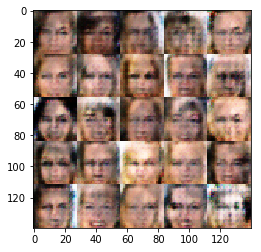

Epoch 1/1... Steps 1010     Discriminator Loss: 1.2105... Generator Loss: 0.8988
Epoch 1/1... Steps 1020     Discriminator Loss: 0.8128... Generator Loss: 1.1926
Epoch 1/1... Steps 1030     Discriminator Loss: 1.4601... Generator Loss: 0.7374
Epoch 1/1... Steps 1040     Discriminator Loss: 1.5287... Generator Loss: 0.5379
Epoch 1/1... Steps 1050     Discriminator Loss: 1.3028... Generator Loss: 0.8976
Epoch 1/1... Steps 1060     Discriminator Loss: 1.3634... Generator Loss: 0.9058
Epoch 1/1... Steps 1070     Discriminator Loss: 1.1944... Generator Loss: 0.9226
Epoch 1/1... Steps 1080     Discriminator Loss: 1.3004... Generator Loss: 0.8781
Epoch 1/1... Steps 1090     Discriminator Loss: 1.5840... Generator Loss: 0.8768
Epoch 1/1... Steps 1100     Discriminator Loss: 2.2157... Generator Loss: 0.1926


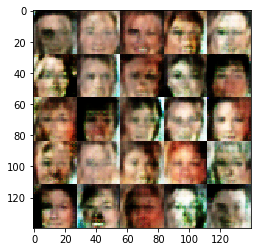

Epoch 1/1... Steps 1110     Discriminator Loss: 1.4139... Generator Loss: 0.4604
Epoch 1/1... Steps 1120     Discriminator Loss: 1.0441... Generator Loss: 0.9742
Epoch 1/1... Steps 1130     Discriminator Loss: 1.3886... Generator Loss: 0.8845
Epoch 1/1... Steps 1140     Discriminator Loss: 1.3324... Generator Loss: 0.6494
Epoch 1/1... Steps 1150     Discriminator Loss: 1.4320... Generator Loss: 0.4648
Epoch 1/1... Steps 1160     Discriminator Loss: 1.0189... Generator Loss: 1.4997
Epoch 1/1... Steps 1170     Discriminator Loss: 1.2521... Generator Loss: 1.2280
Epoch 1/1... Steps 1180     Discriminator Loss: 1.1224... Generator Loss: 1.0181
Epoch 1/1... Steps 1190     Discriminator Loss: 1.4088... Generator Loss: 0.7995
Epoch 1/1... Steps 1200     Discriminator Loss: 1.1131... Generator Loss: 1.0911


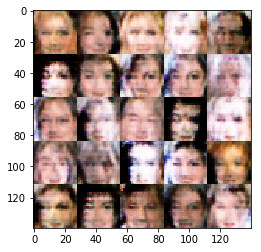

Epoch 1/1... Steps 1210     Discriminator Loss: 1.6230... Generator Loss: 0.3910
Epoch 1/1... Steps 1220     Discriminator Loss: 1.1311... Generator Loss: 1.4528
Epoch 1/1... Steps 1230     Discriminator Loss: 1.3390... Generator Loss: 0.7524
Epoch 1/1... Steps 1240     Discriminator Loss: 1.6795... Generator Loss: 0.3619
Epoch 1/1... Steps 1250     Discriminator Loss: 1.1867... Generator Loss: 0.8075
Epoch 1/1... Steps 1260     Discriminator Loss: 1.3376... Generator Loss: 0.6626
Epoch 1/1... Steps 1270     Discriminator Loss: 1.1184... Generator Loss: 1.0164
Epoch 1/1... Steps 1280     Discriminator Loss: 1.4581... Generator Loss: 0.7173
Epoch 1/1... Steps 1290     Discriminator Loss: 1.2215... Generator Loss: 1.1747
Epoch 1/1... Steps 1300     Discriminator Loss: 1.1566... Generator Loss: 0.8293


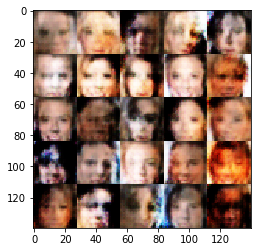

Epoch 1/1... Steps 1310     Discriminator Loss: 1.2724... Generator Loss: 1.0913
Epoch 1/1... Steps 1320     Discriminator Loss: 1.9654... Generator Loss: 2.3390
Epoch 1/1... Steps 1330     Discriminator Loss: 1.1250... Generator Loss: 1.0057
Epoch 1/1... Steps 1340     Discriminator Loss: 1.6087... Generator Loss: 0.4431
Epoch 1/1... Steps 1350     Discriminator Loss: 1.8566... Generator Loss: 0.2638
Epoch 1/1... Steps 1360     Discriminator Loss: 1.8639... Generator Loss: 0.2861
Epoch 1/1... Steps 1370     Discriminator Loss: 1.1397... Generator Loss: 1.0842
Epoch 1/1... Steps 1380     Discriminator Loss: 0.9488... Generator Loss: 1.2833
Epoch 1/1... Steps 1390     Discriminator Loss: 1.1929... Generator Loss: 0.9107
Epoch 1/1... Steps 1400     Discriminator Loss: 1.1795... Generator Loss: 1.2381


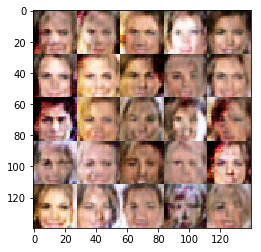

Epoch 1/1... Steps 1410     Discriminator Loss: 1.2513... Generator Loss: 0.8000
Epoch 1/1... Steps 1420     Discriminator Loss: 1.2035... Generator Loss: 1.1351
Epoch 1/1... Steps 1430     Discriminator Loss: 1.1484... Generator Loss: 0.7601
Epoch 1/1... Steps 1440     Discriminator Loss: 0.9610... Generator Loss: 0.9844
Epoch 1/1... Steps 1450     Discriminator Loss: 1.7644... Generator Loss: 0.3387
Epoch 1/1... Steps 1460     Discriminator Loss: 0.9618... Generator Loss: 1.2120
Epoch 1/1... Steps 1470     Discriminator Loss: 0.9734... Generator Loss: 1.5585
Epoch 1/1... Steps 1480     Discriminator Loss: 1.2611... Generator Loss: 0.6990
Epoch 1/1... Steps 1490     Discriminator Loss: 1.3256... Generator Loss: 0.6239
Epoch 1/1... Steps 1500     Discriminator Loss: 1.2247... Generator Loss: 0.7859


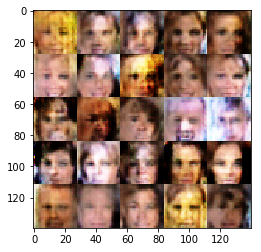

Epoch 1/1... Steps 1510     Discriminator Loss: 1.1138... Generator Loss: 0.7787
Epoch 1/1... Steps 1520     Discriminator Loss: 1.5366... Generator Loss: 0.4197
Epoch 1/1... Steps 1530     Discriminator Loss: 1.2299... Generator Loss: 1.0923
Epoch 1/1... Steps 1540     Discriminator Loss: 1.2166... Generator Loss: 0.6878
Epoch 1/1... Steps 1550     Discriminator Loss: 1.4798... Generator Loss: 2.3651
Epoch 1/1... Steps 1560     Discriminator Loss: 1.1306... Generator Loss: 0.7793
Epoch 1/1... Steps 1570     Discriminator Loss: 1.2578... Generator Loss: 1.6183
Epoch 1/1... Steps 1580     Discriminator Loss: 1.3647... Generator Loss: 0.7149
Epoch 1/1... Steps 1590     Discriminator Loss: 1.3878... Generator Loss: 0.6255
Epoch 1/1... Steps 1600     Discriminator Loss: 0.8847... Generator Loss: 1.5488


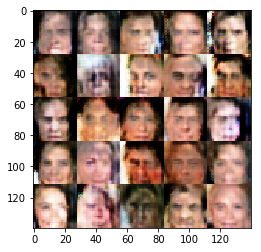

Epoch 1/1... Steps 1610     Discriminator Loss: 1.2279... Generator Loss: 1.2247
Epoch 1/1... Steps 1620     Discriminator Loss: 1.2232... Generator Loss: 0.7980
Epoch 1/1... Steps 1630     Discriminator Loss: 1.3438... Generator Loss: 1.2771
Epoch 1/1... Steps 1640     Discriminator Loss: 1.3317... Generator Loss: 0.6520
Epoch 1/1... Steps 1650     Discriminator Loss: 1.0581... Generator Loss: 1.6089
Epoch 1/1... Steps 1660     Discriminator Loss: 1.1985... Generator Loss: 0.6416
Epoch 1/1... Steps 1670     Discriminator Loss: 1.1193... Generator Loss: 0.6856
Epoch 1/1... Steps 1680     Discriminator Loss: 1.4085... Generator Loss: 0.8144
Epoch 1/1... Steps 1690     Discriminator Loss: 1.3464... Generator Loss: 0.7928
Epoch 1/1... Steps 1700     Discriminator Loss: 1.0786... Generator Loss: 1.1211


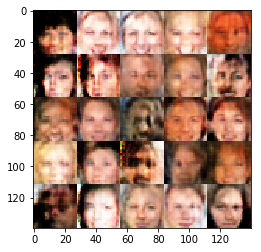

Epoch 1/1... Steps 1710     Discriminator Loss: 1.1896... Generator Loss: 0.9153
Epoch 1/1... Steps 1720     Discriminator Loss: 1.1622... Generator Loss: 1.1437
Epoch 1/1... Steps 1730     Discriminator Loss: 2.0590... Generator Loss: 0.2315
Epoch 1/1... Steps 1740     Discriminator Loss: 0.9762... Generator Loss: 1.5149
Epoch 1/1... Steps 1750     Discriminator Loss: 1.0738... Generator Loss: 0.7802
Epoch 1/1... Steps 1760     Discriminator Loss: 1.0323... Generator Loss: 1.7920
Epoch 1/1... Steps 1770     Discriminator Loss: 1.4994... Generator Loss: 0.4485
Epoch 1/1... Steps 1780     Discriminator Loss: 1.3845... Generator Loss: 0.6061
Epoch 1/1... Steps 1790     Discriminator Loss: 1.4784... Generator Loss: 0.6824
Epoch 1/1... Steps 1800     Discriminator Loss: 1.4067... Generator Loss: 0.7612


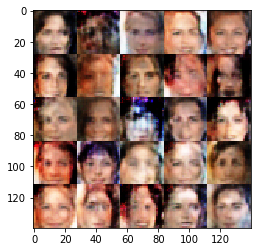

Epoch 1/1... Steps 1810     Discriminator Loss: 1.3712... Generator Loss: 0.8089
Epoch 1/1... Steps 1820     Discriminator Loss: 1.3639... Generator Loss: 0.7983
Epoch 1/1... Steps 1830     Discriminator Loss: 1.1526... Generator Loss: 0.7676
Epoch 1/1... Steps 1840     Discriminator Loss: 1.0065... Generator Loss: 1.2753
Epoch 1/1... Steps 1850     Discriminator Loss: 1.1756... Generator Loss: 1.1851
Epoch 1/1... Steps 1860     Discriminator Loss: 1.1353... Generator Loss: 1.1489
Epoch 1/1... Steps 1870     Discriminator Loss: 1.2253... Generator Loss: 0.6106
Epoch 1/1... Steps 1880     Discriminator Loss: 1.6451... Generator Loss: 0.4590
Epoch 1/1... Steps 1890     Discriminator Loss: 1.1530... Generator Loss: 0.6678
Epoch 1/1... Steps 1900     Discriminator Loss: 1.2289... Generator Loss: 0.7560


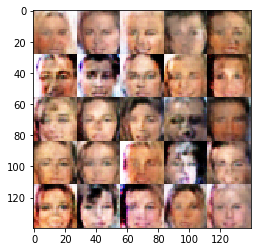

Epoch 1/1... Steps 1910     Discriminator Loss: 1.2840... Generator Loss: 0.9312
Epoch 1/1... Steps 1920     Discriminator Loss: 1.0199... Generator Loss: 0.9412
Epoch 1/1... Steps 1930     Discriminator Loss: 1.3570... Generator Loss: 0.7838
Epoch 1/1... Steps 1940     Discriminator Loss: 1.3185... Generator Loss: 0.9608
Epoch 1/1... Steps 1950     Discriminator Loss: 1.0698... Generator Loss: 1.3970
Epoch 1/1... Steps 1960     Discriminator Loss: 1.2822... Generator Loss: 0.7023
Epoch 1/1... Steps 1970     Discriminator Loss: 1.1002... Generator Loss: 0.8061
Epoch 1/1... Steps 1980     Discriminator Loss: 1.5435... Generator Loss: 0.4507
Epoch 1/1... Steps 1990     Discriminator Loss: 1.6277... Generator Loss: 0.3631
Epoch 1/1... Steps 2000     Discriminator Loss: 1.1942... Generator Loss: 0.8900


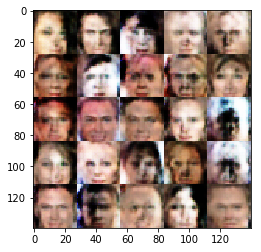

Epoch 1/1... Steps 2010     Discriminator Loss: 1.1880... Generator Loss: 1.4807
Epoch 1/1... Steps 2020     Discriminator Loss: 1.0431... Generator Loss: 1.0459
Epoch 1/1... Steps 2030     Discriminator Loss: 1.2556... Generator Loss: 0.7298
Epoch 1/1... Steps 2040     Discriminator Loss: 1.1097... Generator Loss: 1.1958
Epoch 1/1... Steps 2050     Discriminator Loss: 1.1464... Generator Loss: 1.6743
Epoch 1/1... Steps 2060     Discriminator Loss: 1.1426... Generator Loss: 1.6422
Epoch 1/1... Steps 2070     Discriminator Loss: 0.9610... Generator Loss: 1.0607
Epoch 1/1... Steps 2080     Discriminator Loss: 0.9445... Generator Loss: 0.9987
Epoch 1/1... Steps 2090     Discriminator Loss: 1.3641... Generator Loss: 0.5318
Epoch 1/1... Steps 2100     Discriminator Loss: 1.3733... Generator Loss: 0.6713


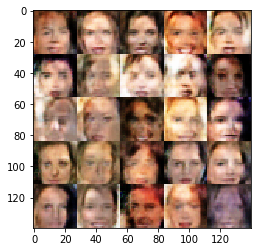

Epoch 1/1... Steps 2110     Discriminator Loss: 1.2885... Generator Loss: 0.5687
Epoch 1/1... Steps 2120     Discriminator Loss: 0.7968... Generator Loss: 1.8139
Epoch 1/1... Steps 2130     Discriminator Loss: 0.9935... Generator Loss: 0.9614
Epoch 1/1... Steps 2140     Discriminator Loss: 1.3356... Generator Loss: 3.0666
Epoch 1/1... Steps 2150     Discriminator Loss: 1.0871... Generator Loss: 1.0834
Epoch 1/1... Steps 2160     Discriminator Loss: 1.2715... Generator Loss: 0.6195
Epoch 1/1... Steps 2170     Discriminator Loss: 1.5673... Generator Loss: 0.4166
Epoch 1/1... Steps 2180     Discriminator Loss: 0.9895... Generator Loss: 0.9795
Epoch 1/1... Steps 2190     Discriminator Loss: 1.0423... Generator Loss: 0.7708
Epoch 1/1... Steps 2200     Discriminator Loss: 1.0717... Generator Loss: 1.1051


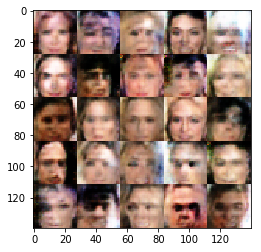

Epoch 1/1... Steps 2210     Discriminator Loss: 1.0196... Generator Loss: 1.1085
Epoch 1/1... Steps 2220     Discriminator Loss: 0.9306... Generator Loss: 1.3505
Epoch 1/1... Steps 2230     Discriminator Loss: 1.0501... Generator Loss: 0.8485
Epoch 1/1... Steps 2240     Discriminator Loss: 1.1290... Generator Loss: 1.0612
Epoch 1/1... Steps 2250     Discriminator Loss: 1.0711... Generator Loss: 2.0907
Epoch 1/1... Steps 2260     Discriminator Loss: 1.2141... Generator Loss: 1.0074
Epoch 1/1... Steps 2270     Discriminator Loss: 1.1363... Generator Loss: 0.8551
Epoch 1/1... Steps 2280     Discriminator Loss: 1.2051... Generator Loss: 1.8830
Epoch 1/1... Steps 2290     Discriminator Loss: 1.3222... Generator Loss: 0.7128
Epoch 1/1... Steps 2300     Discriminator Loss: 1.0261... Generator Loss: 1.2484


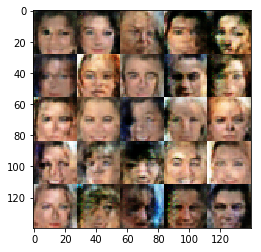

Epoch 1/1... Steps 2310     Discriminator Loss: 0.9142... Generator Loss: 1.4206
Epoch 1/1... Steps 2320     Discriminator Loss: 0.9489... Generator Loss: 2.0044
Epoch 1/1... Steps 2330     Discriminator Loss: 1.2160... Generator Loss: 0.8733
Epoch 1/1... Steps 2340     Discriminator Loss: 1.0875... Generator Loss: 1.1062
Epoch 1/1... Steps 2350     Discriminator Loss: 1.2591... Generator Loss: 1.0756
Epoch 1/1... Steps 2360     Discriminator Loss: 1.5804... Generator Loss: 0.5116
Epoch 1/1... Steps 2370     Discriminator Loss: 1.0460... Generator Loss: 1.3373
Epoch 1/1... Steps 2380     Discriminator Loss: 1.2297... Generator Loss: 0.9055
Epoch 1/1... Steps 2390     Discriminator Loss: 1.2261... Generator Loss: 0.8451
Epoch 1/1... Steps 2400     Discriminator Loss: 1.2739... Generator Loss: 1.1364


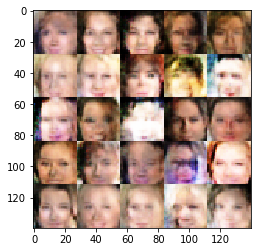

Epoch 1/1... Steps 2410     Discriminator Loss: 1.0492... Generator Loss: 1.1656
Epoch 1/1... Steps 2420     Discriminator Loss: 1.2265... Generator Loss: 0.7336
Epoch 1/1... Steps 2430     Discriminator Loss: 1.3607... Generator Loss: 2.2949
Epoch 1/1... Steps 2440     Discriminator Loss: 1.0638... Generator Loss: 1.7614
Epoch 1/1... Steps 2450     Discriminator Loss: 1.3118... Generator Loss: 1.0072
Epoch 1/1... Steps 2460     Discriminator Loss: 1.1297... Generator Loss: 1.1364
Epoch 1/1... Steps 2470     Discriminator Loss: 1.1048... Generator Loss: 1.2386
Epoch 1/1... Steps 2480     Discriminator Loss: 1.0926... Generator Loss: 1.2331
Epoch 1/1... Steps 2490     Discriminator Loss: 1.2735... Generator Loss: 0.6471
Epoch 1/1... Steps 2500     Discriminator Loss: 1.3646... Generator Loss: 1.1687


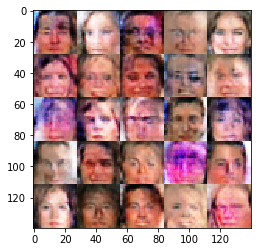

Epoch 1/1... Steps 2510     Discriminator Loss: 1.1509... Generator Loss: 0.7884
Epoch 1/1... Steps 2520     Discriminator Loss: 1.2514... Generator Loss: 0.7118
Epoch 1/1... Steps 2530     Discriminator Loss: 1.1890... Generator Loss: 0.9059
Epoch 1/1... Steps 2540     Discriminator Loss: 1.0562... Generator Loss: 0.7914
Epoch 1/1... Steps 2550     Discriminator Loss: 1.5059... Generator Loss: 0.4334
Epoch 1/1... Steps 2560     Discriminator Loss: 1.0557... Generator Loss: 0.9200
Epoch 1/1... Steps 2570     Discriminator Loss: 0.8039... Generator Loss: 1.7279
Epoch 1/1... Steps 2580     Discriminator Loss: 1.0363... Generator Loss: 1.2040
Epoch 1/1... Steps 2590     Discriminator Loss: 0.9265... Generator Loss: 1.3544
Epoch 1/1... Steps 2600     Discriminator Loss: 1.1699... Generator Loss: 2.6222


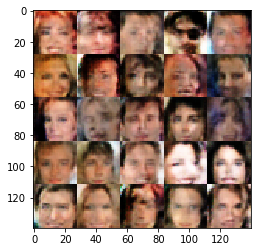

Epoch 1/1... Steps 2610     Discriminator Loss: 0.8005... Generator Loss: 1.4927
Epoch 1/1... Steps 2620     Discriminator Loss: 1.3879... Generator Loss: 1.0010
Epoch 1/1... Steps 2630     Discriminator Loss: 1.1237... Generator Loss: 1.1021
Epoch 1/1... Steps 2640     Discriminator Loss: 1.5972... Generator Loss: 0.4435
Epoch 1/1... Steps 2650     Discriminator Loss: 1.3030... Generator Loss: 0.8281
Epoch 1/1... Steps 2660     Discriminator Loss: 1.0843... Generator Loss: 1.1707
Epoch 1/1... Steps 2670     Discriminator Loss: 1.1451... Generator Loss: 1.0583
Epoch 1/1... Steps 2680     Discriminator Loss: 0.9936... Generator Loss: 2.1235
Epoch 1/1... Steps 2690     Discriminator Loss: 1.3446... Generator Loss: 1.1097
Epoch 1/1... Steps 2700     Discriminator Loss: 1.0322... Generator Loss: 1.3901


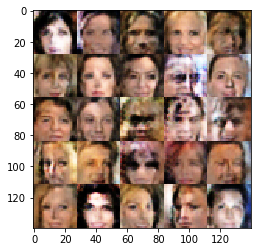

Epoch 1/1... Steps 2710     Discriminator Loss: 0.7915... Generator Loss: 2.1317
Epoch 1/1... Steps 2720     Discriminator Loss: 1.4327... Generator Loss: 0.9016
Epoch 1/1... Steps 2730     Discriminator Loss: 1.6777... Generator Loss: 0.3697
Epoch 1/1... Steps 2740     Discriminator Loss: 1.1630... Generator Loss: 0.7944
Epoch 1/1... Steps 2750     Discriminator Loss: 1.0026... Generator Loss: 2.0349
Epoch 1/1... Steps 2760     Discriminator Loss: 1.1351... Generator Loss: 1.9059
Epoch 1/1... Steps 2770     Discriminator Loss: 0.8993... Generator Loss: 1.0659
Epoch 1/1... Steps 2780     Discriminator Loss: 1.1196... Generator Loss: 0.8513
Epoch 1/1... Steps 2790     Discriminator Loss: 0.8716... Generator Loss: 1.8652
Epoch 1/1... Steps 2800     Discriminator Loss: 0.9309... Generator Loss: 1.1582


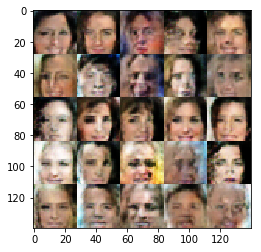

Epoch 1/1... Steps 2810     Discriminator Loss: 0.9259... Generator Loss: 1.2321
Epoch 1/1... Steps 2820     Discriminator Loss: 1.2197... Generator Loss: 0.6902
Epoch 1/1... Steps 2830     Discriminator Loss: 1.1277... Generator Loss: 0.8088
Epoch 1/1... Steps 2840     Discriminator Loss: 1.7913... Generator Loss: 0.7828
Epoch 1/1... Steps 2850     Discriminator Loss: 1.3403... Generator Loss: 0.7963
Epoch 1/1... Steps 2860     Discriminator Loss: 1.4534... Generator Loss: 0.5652
Epoch 1/1... Steps 2870     Discriminator Loss: 1.1156... Generator Loss: 0.7571
Epoch 1/1... Steps 2880     Discriminator Loss: 0.8110... Generator Loss: 1.4825
Epoch 1/1... Steps 2890     Discriminator Loss: 0.6586... Generator Loss: 2.0900
Epoch 1/1... Steps 2900     Discriminator Loss: 1.5075... Generator Loss: 0.5510


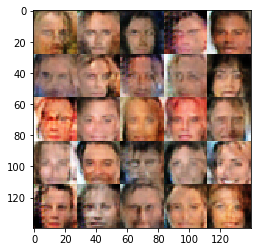

Epoch 1/1... Steps 2910     Discriminator Loss: 1.1290... Generator Loss: 1.1278
Epoch 1/1... Steps 2920     Discriminator Loss: 0.9703... Generator Loss: 1.0788
Epoch 1/1... Steps 2930     Discriminator Loss: 1.2148... Generator Loss: 1.1450
Epoch 1/1... Steps 2940     Discriminator Loss: 1.2283... Generator Loss: 0.8820
Epoch 1/1... Steps 2950     Discriminator Loss: 1.1694... Generator Loss: 1.1200
Epoch 1/1... Steps 2960     Discriminator Loss: 1.2469... Generator Loss: 2.3221
Epoch 1/1... Steps 2970     Discriminator Loss: 1.0176... Generator Loss: 1.7679
Epoch 1/1... Steps 2980     Discriminator Loss: 0.8778... Generator Loss: 1.2057
Epoch 1/1... Steps 2990     Discriminator Loss: 1.1746... Generator Loss: 0.7239
Epoch 1/1... Steps 3000     Discriminator Loss: 1.0165... Generator Loss: 0.8800


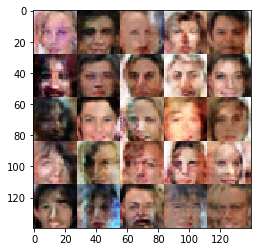

Epoch 1/1... Steps 3010     Discriminator Loss: 1.0683... Generator Loss: 0.9612
Epoch 1/1... Steps 3020     Discriminator Loss: 1.3300... Generator Loss: 0.5253
Epoch 1/1... Steps 3030     Discriminator Loss: 1.1849... Generator Loss: 0.9062
Epoch 1/1... Steps 3040     Discriminator Loss: 1.3396... Generator Loss: 0.5380
Epoch 1/1... Steps 3050     Discriminator Loss: 0.9986... Generator Loss: 1.1148
Epoch 1/1... Steps 3060     Discriminator Loss: 1.5302... Generator Loss: 0.4654
Epoch 1/1... Steps 3070     Discriminator Loss: 1.2195... Generator Loss: 0.6080
Epoch 1/1... Steps 3080     Discriminator Loss: 1.1180... Generator Loss: 0.8553
Epoch 1/1... Steps 3090     Discriminator Loss: 0.9659... Generator Loss: 1.3009
Epoch 1/1... Steps 3100     Discriminator Loss: 0.9476... Generator Loss: 2.1661


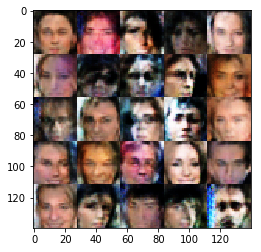

Epoch 1/1... Steps 3110     Discriminator Loss: 1.4935... Generator Loss: 0.4730
Epoch 1/1... Steps 3120     Discriminator Loss: 1.3199... Generator Loss: 1.2483
Epoch 1/1... Steps 3130     Discriminator Loss: 1.2526... Generator Loss: 0.6412
Epoch 1/1... Steps 3140     Discriminator Loss: 0.9452... Generator Loss: 1.4500
Epoch 1/1... Steps 3150     Discriminator Loss: 1.2357... Generator Loss: 0.7249
Epoch 1/1... Steps 3160     Discriminator Loss: 0.8341... Generator Loss: 1.8622
Epoch 1/1... Steps 3170     Discriminator Loss: 1.0403... Generator Loss: 1.2073
Epoch 1/1... Steps 3180     Discriminator Loss: 1.3298... Generator Loss: 0.6012
Epoch 1/1... Steps 3190     Discriminator Loss: 0.9314... Generator Loss: 1.6745
Epoch 1/1... Steps 3200     Discriminator Loss: 1.0152... Generator Loss: 1.0371


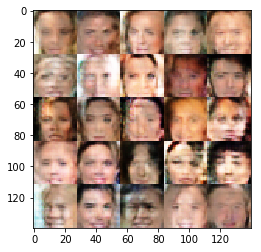

Epoch 1/1... Steps 3210     Discriminator Loss: 0.9985... Generator Loss: 1.2341
Epoch 1/1... Steps 3220     Discriminator Loss: 1.2755... Generator Loss: 0.9852
Epoch 1/1... Steps 3230     Discriminator Loss: 2.1601... Generator Loss: 0.2207
Epoch 1/1... Steps 3240     Discriminator Loss: 1.3446... Generator Loss: 0.8106
Epoch 1/1... Steps 3250     Discriminator Loss: 1.0896... Generator Loss: 0.8420
Epoch 1/1... Steps 3260     Discriminator Loss: 0.8729... Generator Loss: 1.6586
Epoch 1/1... Steps 3270     Discriminator Loss: 1.0073... Generator Loss: 1.5831
Epoch 1/1... Steps 3280     Discriminator Loss: 1.4695... Generator Loss: 0.5325
Epoch 1/1... Steps 3290     Discriminator Loss: 1.6298... Generator Loss: 0.4673
Epoch 1/1... Steps 3300     Discriminator Loss: 0.9109... Generator Loss: 1.3267


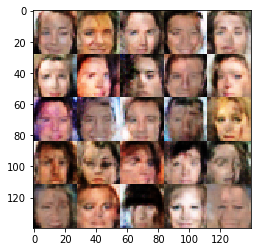

Epoch 1/1... Steps 3310     Discriminator Loss: 1.0785... Generator Loss: 0.8451
Epoch 1/1... Steps 3320     Discriminator Loss: 0.9441... Generator Loss: 1.0858
Epoch 1/1... Steps 3330     Discriminator Loss: 0.9447... Generator Loss: 1.1721
Epoch 1/1... Steps 3340     Discriminator Loss: 0.9745... Generator Loss: 1.0825
Epoch 1/1... Steps 3350     Discriminator Loss: 1.2131... Generator Loss: 0.8314
Epoch 1/1... Steps 3360     Discriminator Loss: 1.2702... Generator Loss: 0.7325
Epoch 1/1... Steps 3370     Discriminator Loss: 1.1203... Generator Loss: 0.7353
Epoch 1/1... Steps 3380     Discriminator Loss: 1.2696... Generator Loss: 0.7189
Epoch 1/1... Steps 3390     Discriminator Loss: 1.0404... Generator Loss: 0.9829
Epoch 1/1... Steps 3400     Discriminator Loss: 1.2256... Generator Loss: 1.5396


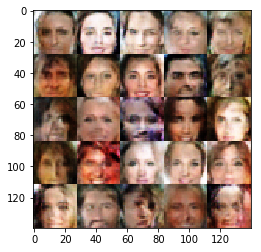

Epoch 1/1... Steps 3410     Discriminator Loss: 1.3533... Generator Loss: 1.7370
Epoch 1/1... Steps 3420     Discriminator Loss: 1.2219... Generator Loss: 1.9235
Epoch 1/1... Steps 3430     Discriminator Loss: 1.0903... Generator Loss: 1.1605
Epoch 1/1... Steps 3440     Discriminator Loss: 1.2616... Generator Loss: 2.2399
Epoch 1/1... Steps 3450     Discriminator Loss: 0.8411... Generator Loss: 2.2109
Epoch 1/1... Steps 3460     Discriminator Loss: 1.0262... Generator Loss: 0.9100
Epoch 1/1... Steps 3470     Discriminator Loss: 1.1998... Generator Loss: 2.3152
Epoch 1/1... Steps 3480     Discriminator Loss: 1.0217... Generator Loss: 1.0235
Epoch 1/1... Steps 3490     Discriminator Loss: 0.9705... Generator Loss: 1.3249
Epoch 1/1... Steps 3500     Discriminator Loss: 1.2353... Generator Loss: 1.4852


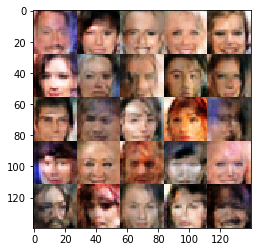

Epoch 1/1... Steps 3510     Discriminator Loss: 1.2360... Generator Loss: 1.0264
Epoch 1/1... Steps 3520     Discriminator Loss: 1.1539... Generator Loss: 0.8488
Epoch 1/1... Steps 3530     Discriminator Loss: 0.9607... Generator Loss: 1.0996
Epoch 1/1... Steps 3540     Discriminator Loss: 1.1731... Generator Loss: 3.2089
Epoch 1/1... Steps 3550     Discriminator Loss: 0.9452... Generator Loss: 1.1883
Epoch 1/1... Steps 3560     Discriminator Loss: 0.9624... Generator Loss: 1.5721
Epoch 1/1... Steps 3570     Discriminator Loss: 0.8509... Generator Loss: 1.6254
Epoch 1/1... Steps 3580     Discriminator Loss: 0.8361... Generator Loss: 1.3665
Epoch 1/1... Steps 3590     Discriminator Loss: 1.5896... Generator Loss: 0.3793
Epoch 1/1... Steps 3600     Discriminator Loss: 1.2680... Generator Loss: 1.6516


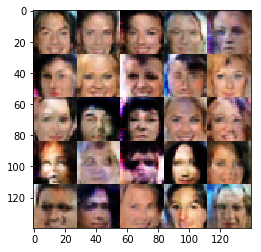

Epoch 1/1... Steps 3610     Discriminator Loss: 0.9229... Generator Loss: 1.6730
Epoch 1/1... Steps 3620     Discriminator Loss: 1.1756... Generator Loss: 0.7948
Epoch 1/1... Steps 3630     Discriminator Loss: 0.9259... Generator Loss: 1.3727
Epoch 1/1... Steps 3640     Discriminator Loss: 1.1794... Generator Loss: 0.8180
Epoch 1/1... Steps 3650     Discriminator Loss: 0.9623... Generator Loss: 1.5390
Epoch 1/1... Steps 3660     Discriminator Loss: 1.2813... Generator Loss: 0.8312
Epoch 1/1... Steps 3670     Discriminator Loss: 1.0842... Generator Loss: 0.9311
Epoch 1/1... Steps 3680     Discriminator Loss: 0.8686... Generator Loss: 1.8780
Epoch 1/1... Steps 3690     Discriminator Loss: 1.0937... Generator Loss: 1.1784
Epoch 1/1... Steps 3700     Discriminator Loss: 1.1424... Generator Loss: 1.7830


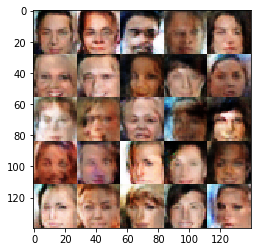

Epoch 1/1... Steps 3710     Discriminator Loss: 1.1195... Generator Loss: 0.7959
Epoch 1/1... Steps 3720     Discriminator Loss: 1.5310... Generator Loss: 0.4803
Epoch 1/1... Steps 3730     Discriminator Loss: 1.1230... Generator Loss: 0.9069
Epoch 1/1... Steps 3740     Discriminator Loss: 1.7405... Generator Loss: 2.0905
Epoch 1/1... Steps 3750     Discriminator Loss: 1.1672... Generator Loss: 1.0778
Epoch 1/1... Steps 3760     Discriminator Loss: 1.0918... Generator Loss: 0.9382
Epoch 1/1... Steps 3770     Discriminator Loss: 1.0942... Generator Loss: 1.1886
Epoch 1/1... Steps 3780     Discriminator Loss: 1.0344... Generator Loss: 1.1634
Epoch 1/1... Steps 3790     Discriminator Loss: 0.9678... Generator Loss: 1.4000
Epoch 1/1... Steps 3800     Discriminator Loss: 1.0869... Generator Loss: 1.0412


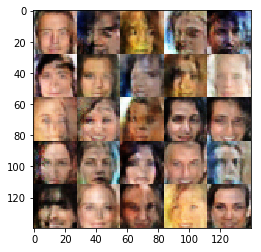

Epoch 1/1... Steps 3810     Discriminator Loss: 0.8832... Generator Loss: 1.3827
Epoch 1/1... Steps 3820     Discriminator Loss: 0.9849... Generator Loss: 1.2605
Epoch 1/1... Steps 3830     Discriminator Loss: 0.9670... Generator Loss: 1.7228
Epoch 1/1... Steps 3840     Discriminator Loss: 1.1909... Generator Loss: 1.8814
Epoch 1/1... Steps 3850     Discriminator Loss: 1.0222... Generator Loss: 0.9952
Epoch 1/1... Steps 3860     Discriminator Loss: 0.9156... Generator Loss: 1.6561
Epoch 1/1... Steps 3870     Discriminator Loss: 0.9931... Generator Loss: 1.0928
Epoch 1/1... Steps 3880     Discriminator Loss: 1.2458... Generator Loss: 0.7420
Epoch 1/1... Steps 3890     Discriminator Loss: 1.0398... Generator Loss: 1.6684
Epoch 1/1... Steps 3900     Discriminator Loss: 0.9068... Generator Loss: 1.7872


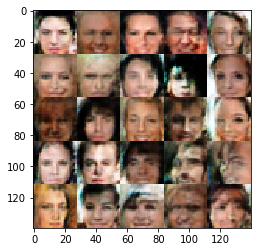

Epoch 1/1... Steps 3910     Discriminator Loss: 1.1960... Generator Loss: 0.8961
Epoch 1/1... Steps 3920     Discriminator Loss: 1.0567... Generator Loss: 1.0229
Epoch 1/1... Steps 3930     Discriminator Loss: 1.1405... Generator Loss: 1.0326
Epoch 1/1... Steps 3940     Discriminator Loss: 1.3000... Generator Loss: 0.9800
Epoch 1/1... Steps 3950     Discriminator Loss: 1.0341... Generator Loss: 1.1603
Epoch 1/1... Steps 3960     Discriminator Loss: 1.1779... Generator Loss: 0.8372
Epoch 1/1... Steps 3970     Discriminator Loss: 0.9926... Generator Loss: 1.4762
Epoch 1/1... Steps 3980     Discriminator Loss: 1.1882... Generator Loss: 1.6386
Epoch 1/1... Steps 3990     Discriminator Loss: 0.9862... Generator Loss: 1.0331
Epoch 1/1... Steps 4000     Discriminator Loss: 0.9248... Generator Loss: 1.6881


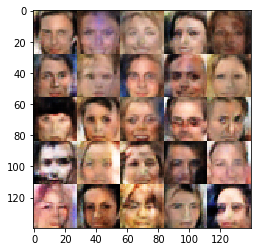

Epoch 1/1... Steps 4010     Discriminator Loss: 1.0278... Generator Loss: 0.9903
Epoch 1/1... Steps 4020     Discriminator Loss: 1.1231... Generator Loss: 1.1906
Epoch 1/1... Steps 4030     Discriminator Loss: 1.1438... Generator Loss: 1.9748
Epoch 1/1... Steps 4040     Discriminator Loss: 1.1627... Generator Loss: 0.9391
Epoch 1/1... Steps 4050     Discriminator Loss: 1.0643... Generator Loss: 1.5278
Epoch 1/1... Steps 4060     Discriminator Loss: 1.5254... Generator Loss: 0.4994
Epoch 1/1... Steps 4070     Discriminator Loss: 1.1442... Generator Loss: 1.4528
Epoch 1/1... Steps 4080     Discriminator Loss: 1.2807... Generator Loss: 0.6097
Epoch 1/1... Steps 4090     Discriminator Loss: 0.9755... Generator Loss: 1.7080
Epoch 1/1... Steps 4100     Discriminator Loss: 1.1392... Generator Loss: 1.0755


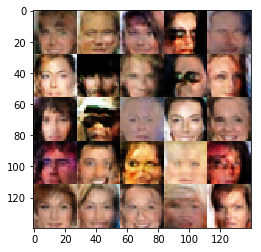

Epoch 1/1... Steps 4110     Discriminator Loss: 1.0069... Generator Loss: 1.0240
Epoch 1/1... Steps 4120     Discriminator Loss: 1.7435... Generator Loss: 0.4078
Epoch 1/1... Steps 4130     Discriminator Loss: 1.2713... Generator Loss: 0.8640
Epoch 1/1... Steps 4140     Discriminator Loss: 1.1748... Generator Loss: 0.8205
Epoch 1/1... Steps 4150     Discriminator Loss: 1.3799... Generator Loss: 0.4719
Epoch 1/1... Steps 4160     Discriminator Loss: 1.3583... Generator Loss: 0.5643
Epoch 1/1... Steps 4170     Discriminator Loss: 1.4115... Generator Loss: 0.5542
Epoch 1/1... Steps 4180     Discriminator Loss: 1.0788... Generator Loss: 0.7107
Epoch 1/1... Steps 4190     Discriminator Loss: 1.2605... Generator Loss: 0.7764
Epoch 1/1... Steps 4200     Discriminator Loss: 1.1394... Generator Loss: 0.9625


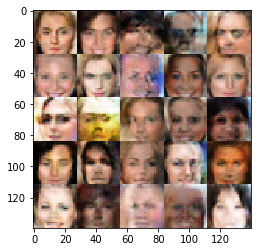

Epoch 1/1... Steps 4210     Discriminator Loss: 1.0160... Generator Loss: 1.0912
Epoch 1/1... Steps 4220     Discriminator Loss: 0.9260... Generator Loss: 1.3887
Epoch 1/1... Steps 4230     Discriminator Loss: 1.2024... Generator Loss: 0.8072
Epoch 1/1... Steps 4240     Discriminator Loss: 1.0207... Generator Loss: 1.5822
Epoch 1/1... Steps 4250     Discriminator Loss: 1.1728... Generator Loss: 0.9567
Epoch 1/1... Steps 4260     Discriminator Loss: 0.9599... Generator Loss: 1.2760
Epoch 1/1... Steps 4270     Discriminator Loss: 1.1502... Generator Loss: 0.9011
Epoch 1/1... Steps 4280     Discriminator Loss: 1.2562... Generator Loss: 0.7594
Epoch 1/1... Steps 4290     Discriminator Loss: 0.8039... Generator Loss: 1.9955
Epoch 1/1... Steps 4300     Discriminator Loss: 1.0795... Generator Loss: 0.9703


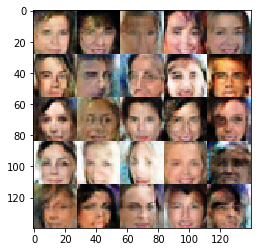

Epoch 1/1... Steps 4310     Discriminator Loss: 1.1367... Generator Loss: 1.1773
Epoch 1/1... Steps 4320     Discriminator Loss: 1.0977... Generator Loss: 1.0528
Epoch 1/1... Steps 4330     Discriminator Loss: 1.4319... Generator Loss: 0.6333
Epoch 1/1... Steps 4340     Discriminator Loss: 1.1152... Generator Loss: 0.8380
Epoch 1/1... Steps 4350     Discriminator Loss: 1.2701... Generator Loss: 0.7337
Epoch 1/1... Steps 4360     Discriminator Loss: 1.0184... Generator Loss: 1.3371
Epoch 1/1... Steps 4370     Discriminator Loss: 1.1944... Generator Loss: 0.8159
Epoch 1/1... Steps 4380     Discriminator Loss: 1.1939... Generator Loss: 2.2560
Epoch 1/1... Steps 4390     Discriminator Loss: 1.1380... Generator Loss: 1.1241
Epoch 1/1... Steps 4400     Discriminator Loss: 1.1523... Generator Loss: 0.6428


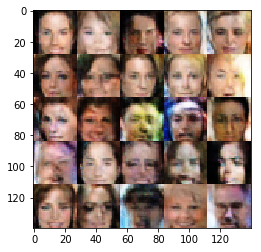

Epoch 1/1... Steps 4410     Discriminator Loss: 1.1821... Generator Loss: 0.8680
Epoch 1/1... Steps 4420     Discriminator Loss: 1.1226... Generator Loss: 1.5718
Epoch 1/1... Steps 4430     Discriminator Loss: 0.9779... Generator Loss: 1.3319
Epoch 1/1... Steps 4440     Discriminator Loss: 1.1421... Generator Loss: 0.6817
Epoch 1/1... Steps 4450     Discriminator Loss: 1.1434... Generator Loss: 0.6868
Epoch 1/1... Steps 4460     Discriminator Loss: 0.9685... Generator Loss: 0.9932
Epoch 1/1... Steps 4470     Discriminator Loss: 1.3906... Generator Loss: 0.5905
Epoch 1/1... Steps 4480     Discriminator Loss: 1.0723... Generator Loss: 1.4286
Epoch 1/1... Steps 4490     Discriminator Loss: 1.1515... Generator Loss: 0.7058
Epoch 1/1... Steps 4500     Discriminator Loss: 1.0666... Generator Loss: 1.0665


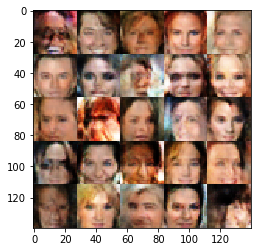

Epoch 1/1... Steps 4510     Discriminator Loss: 1.1370... Generator Loss: 0.8841
Epoch 1/1... Steps 4520     Discriminator Loss: 1.1103... Generator Loss: 1.0280
Epoch 1/1... Steps 4530     Discriminator Loss: 0.9354... Generator Loss: 1.8417
Epoch 1/1... Steps 4540     Discriminator Loss: 1.1478... Generator Loss: 0.7534
Epoch 1/1... Steps 4550     Discriminator Loss: 1.1054... Generator Loss: 0.9739
Epoch 1/1... Steps 4560     Discriminator Loss: 1.1172... Generator Loss: 1.1394
Epoch 1/1... Steps 4570     Discriminator Loss: 1.1470... Generator Loss: 0.8616
Epoch 1/1... Steps 4580     Discriminator Loss: 1.3398... Generator Loss: 0.5152
Epoch 1/1... Steps 4590     Discriminator Loss: 1.0801... Generator Loss: 1.1974
Epoch 1/1... Steps 4600     Discriminator Loss: 1.0601... Generator Loss: 1.0035


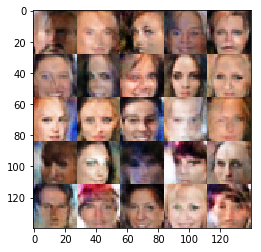

Epoch 1/1... Steps 4610     Discriminator Loss: 1.1009... Generator Loss: 1.0615
Epoch 1/1... Steps 4620     Discriminator Loss: 1.8212... Generator Loss: 0.9929
Epoch 1/1... Steps 4630     Discriminator Loss: 1.1195... Generator Loss: 0.8031
Epoch 1/1... Steps 4640     Discriminator Loss: 1.6937... Generator Loss: 0.3862
Epoch 1/1... Steps 4650     Discriminator Loss: 1.7310... Generator Loss: 0.3110
Epoch 1/1... Steps 4660     Discriminator Loss: 1.1933... Generator Loss: 0.8747
Epoch 1/1... Steps 4670     Discriminator Loss: 1.1471... Generator Loss: 1.3159
Epoch 1/1... Steps 4680     Discriminator Loss: 1.3211... Generator Loss: 0.6971
Epoch 1/1... Steps 4690     Discriminator Loss: 1.2357... Generator Loss: 1.0070
Epoch 1/1... Steps 4700     Discriminator Loss: 1.1543... Generator Loss: 1.1589


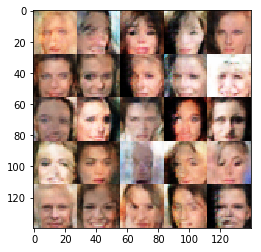

Epoch 1/1... Steps 4710     Discriminator Loss: 1.1038... Generator Loss: 1.5473
Epoch 1/1... Steps 4720     Discriminator Loss: 1.0114... Generator Loss: 2.6010
Epoch 1/1... Steps 4730     Discriminator Loss: 1.2951... Generator Loss: 0.7276
Epoch 1/1... Steps 4740     Discriminator Loss: 1.0205... Generator Loss: 1.9201
Epoch 1/1... Steps 4750     Discriminator Loss: 1.0366... Generator Loss: 1.2678
Epoch 1/1... Steps 4760     Discriminator Loss: 1.0724... Generator Loss: 1.3237
Epoch 1/1... Steps 4770     Discriminator Loss: 1.1632... Generator Loss: 1.3077
Epoch 1/1... Steps 4780     Discriminator Loss: 1.3756... Generator Loss: 0.6638
Epoch 1/1... Steps 4790     Discriminator Loss: 1.2782... Generator Loss: 1.0157
Epoch 1/1... Steps 4800     Discriminator Loss: 1.0319... Generator Loss: 1.0775


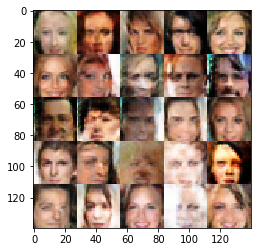

Epoch 1/1... Steps 4810     Discriminator Loss: 1.2443... Generator Loss: 0.6590
Epoch 1/1... Steps 4820     Discriminator Loss: 1.2732... Generator Loss: 0.8465
Epoch 1/1... Steps 4830     Discriminator Loss: 1.2395... Generator Loss: 0.8272
Epoch 1/1... Steps 4840     Discriminator Loss: 1.4849... Generator Loss: 0.4686
Epoch 1/1... Steps 4850     Discriminator Loss: 1.1781... Generator Loss: 0.7367
Epoch 1/1... Steps 4860     Discriminator Loss: 1.2156... Generator Loss: 0.6439
Epoch 1/1... Steps 4870     Discriminator Loss: 1.3098... Generator Loss: 0.4917
Epoch 1/1... Steps 4880     Discriminator Loss: 1.1614... Generator Loss: 0.7456
Epoch 1/1... Steps 4890     Discriminator Loss: 1.3627... Generator Loss: 0.5598
Epoch 1/1... Steps 4900     Discriminator Loss: 1.1097... Generator Loss: 1.4904


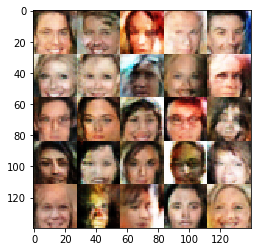

Epoch 1/1... Steps 4910     Discriminator Loss: 1.3923... Generator Loss: 2.0142
Epoch 1/1... Steps 4920     Discriminator Loss: 1.1308... Generator Loss: 1.2338
Epoch 1/1... Steps 4930     Discriminator Loss: 0.9215... Generator Loss: 1.2333
Epoch 1/1... Steps 4940     Discriminator Loss: 1.5898... Generator Loss: 0.4713
Epoch 1/1... Steps 4950     Discriminator Loss: 1.7447... Generator Loss: 0.3310
Epoch 1/1... Steps 4960     Discriminator Loss: 1.0933... Generator Loss: 0.9762
Epoch 1/1... Steps 4970     Discriminator Loss: 1.1847... Generator Loss: 0.9366
Epoch 1/1... Steps 4980     Discriminator Loss: 1.1497... Generator Loss: 0.8375
Epoch 1/1... Steps 4990     Discriminator Loss: 1.3313... Generator Loss: 1.0810
Epoch 1/1... Steps 5000     Discriminator Loss: 1.1210... Generator Loss: 0.8122


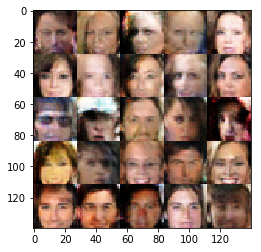

Epoch 1/1... Steps 5010     Discriminator Loss: 1.1471... Generator Loss: 0.8753
Epoch 1/1... Steps 5020     Discriminator Loss: 1.4458... Generator Loss: 0.4896
Epoch 1/1... Steps 5030     Discriminator Loss: 1.1069... Generator Loss: 0.9437
Epoch 1/1... Steps 5040     Discriminator Loss: 1.4558... Generator Loss: 0.5859
Epoch 1/1... Steps 5050     Discriminator Loss: 1.1965... Generator Loss: 0.9682
Epoch 1/1... Steps 5060     Discriminator Loss: 0.9682... Generator Loss: 1.2545
Epoch 1/1... Steps 5070     Discriminator Loss: 1.0533... Generator Loss: 1.1290
Epoch 1/1... Steps 5080     Discriminator Loss: 1.1978... Generator Loss: 0.9504
Epoch 1/1... Steps 5090     Discriminator Loss: 1.2678... Generator Loss: 1.2382
Epoch 1/1... Steps 5100     Discriminator Loss: 1.1451... Generator Loss: 1.2194


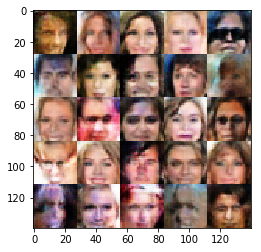

Epoch 1/1... Steps 5110     Discriminator Loss: 1.6593... Generator Loss: 0.3589
Epoch 1/1... Steps 5120     Discriminator Loss: 1.0305... Generator Loss: 1.1209
Epoch 1/1... Steps 5130     Discriminator Loss: 1.1804... Generator Loss: 1.1405
Epoch 1/1... Steps 5140     Discriminator Loss: 1.0152... Generator Loss: 1.7385
Epoch 1/1... Steps 5150     Discriminator Loss: 1.0865... Generator Loss: 1.1933
Epoch 1/1... Steps 5160     Discriminator Loss: 1.0064... Generator Loss: 1.2956
Epoch 1/1... Steps 5170     Discriminator Loss: 0.9851... Generator Loss: 1.1291
Epoch 1/1... Steps 5180     Discriminator Loss: 1.2065... Generator Loss: 0.9752
Epoch 1/1... Steps 5190     Discriminator Loss: 1.0215... Generator Loss: 1.3362
Epoch 1/1... Steps 5200     Discriminator Loss: 0.9723... Generator Loss: 1.4385


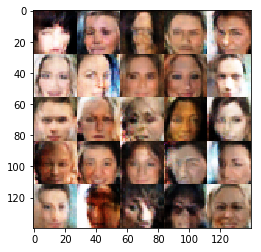

Epoch 1/1... Steps 5210     Discriminator Loss: 1.2600... Generator Loss: 0.6629
Epoch 1/1... Steps 5220     Discriminator Loss: 0.9787... Generator Loss: 1.1628
Epoch 1/1... Steps 5230     Discriminator Loss: 1.2195... Generator Loss: 1.0515
Epoch 1/1... Steps 5240     Discriminator Loss: 1.1231... Generator Loss: 1.3782
Epoch 1/1... Steps 5250     Discriminator Loss: 1.1700... Generator Loss: 0.7836
Epoch 1/1... Steps 5260     Discriminator Loss: 1.1576... Generator Loss: 0.8576
Epoch 1/1... Steps 5270     Discriminator Loss: 1.1414... Generator Loss: 1.1259
Epoch 1/1... Steps 5280     Discriminator Loss: 0.9998... Generator Loss: 1.2532
Epoch 1/1... Steps 5290     Discriminator Loss: 1.3659... Generator Loss: 0.5642
Epoch 1/1... Steps 5300     Discriminator Loss: 1.4602... Generator Loss: 0.4774


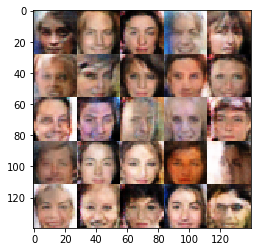

Epoch 1/1... Steps 5310     Discriminator Loss: 1.1443... Generator Loss: 0.9029
Epoch 1/1... Steps 5320     Discriminator Loss: 0.9706... Generator Loss: 1.1080
Epoch 1/1... Steps 5330     Discriminator Loss: 1.4560... Generator Loss: 0.9947
Epoch 1/1... Steps 5340     Discriminator Loss: 1.1328... Generator Loss: 1.3847
Epoch 1/1... Steps 5350     Discriminator Loss: 1.1101... Generator Loss: 0.9075
Epoch 1/1... Steps 5360     Discriminator Loss: 1.3379... Generator Loss: 1.5012
Epoch 1/1... Steps 5370     Discriminator Loss: 1.0385... Generator Loss: 1.3095
Epoch 1/1... Steps 5380     Discriminator Loss: 0.9678... Generator Loss: 1.2573
Epoch 1/1... Steps 5390     Discriminator Loss: 1.0075... Generator Loss: 1.2333
Epoch 1/1... Steps 5400     Discriminator Loss: 1.0412... Generator Loss: 0.9903


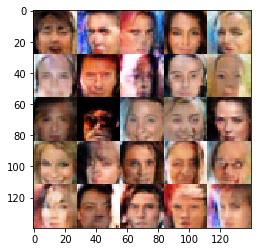

Epoch 1/1... Steps 5410     Discriminator Loss: 1.1860... Generator Loss: 0.6860
Epoch 1/1... Steps 5420     Discriminator Loss: 1.0695... Generator Loss: 1.1295
Epoch 1/1... Steps 5430     Discriminator Loss: 1.0576... Generator Loss: 1.2760
Epoch 1/1... Steps 5440     Discriminator Loss: 1.1347... Generator Loss: 1.1110
Epoch 1/1... Steps 5450     Discriminator Loss: 1.3750... Generator Loss: 0.5957
Epoch 1/1... Steps 5460     Discriminator Loss: 1.2017... Generator Loss: 0.7666
Epoch 1/1... Steps 5470     Discriminator Loss: 1.2478... Generator Loss: 0.6472
Epoch 1/1... Steps 5480     Discriminator Loss: 1.3690... Generator Loss: 0.5455
Epoch 1/1... Steps 5490     Discriminator Loss: 1.3146... Generator Loss: 0.9045
Epoch 1/1... Steps 5500     Discriminator Loss: 1.2080... Generator Loss: 1.4641


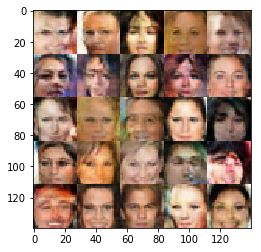

Epoch 1/1... Steps 5510     Discriminator Loss: 1.1874... Generator Loss: 1.2414
Epoch 1/1... Steps 5520     Discriminator Loss: 1.1721... Generator Loss: 0.9726
Epoch 1/1... Steps 5530     Discriminator Loss: 1.1196... Generator Loss: 0.8786
Epoch 1/1... Steps 5540     Discriminator Loss: 1.2663... Generator Loss: 0.5828
Epoch 1/1... Steps 5550     Discriminator Loss: 1.1713... Generator Loss: 0.7611
Epoch 1/1... Steps 5560     Discriminator Loss: 1.2243... Generator Loss: 0.8951
Epoch 1/1... Steps 5570     Discriminator Loss: 1.2870... Generator Loss: 0.5979
Epoch 1/1... Steps 5580     Discriminator Loss: 1.1213... Generator Loss: 1.4613
Epoch 1/1... Steps 5590     Discriminator Loss: 1.2510... Generator Loss: 1.3598
Epoch 1/1... Steps 5600     Discriminator Loss: 1.5792... Generator Loss: 0.3461


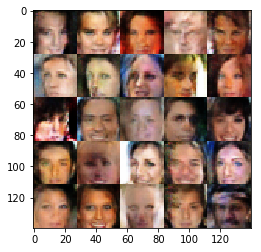

Epoch 1/1... Steps 5610     Discriminator Loss: 1.1415... Generator Loss: 0.7741
Epoch 1/1... Steps 5620     Discriminator Loss: 1.0908... Generator Loss: 0.9402
Epoch 1/1... Steps 5630     Discriminator Loss: 1.3056... Generator Loss: 0.6676
Epoch 1/1... Steps 5640     Discriminator Loss: 1.0352... Generator Loss: 1.3112
Epoch 1/1... Steps 5650     Discriminator Loss: 1.1993... Generator Loss: 0.9086
Epoch 1/1... Steps 5660     Discriminator Loss: 1.3568... Generator Loss: 0.6591
Epoch 1/1... Steps 5670     Discriminator Loss: 1.3137... Generator Loss: 1.7147
Epoch 1/1... Steps 5680     Discriminator Loss: 1.2858... Generator Loss: 0.7729
Epoch 1/1... Steps 5690     Discriminator Loss: 1.2399... Generator Loss: 0.6178
Epoch 1/1... Steps 5700     Discriminator Loss: 1.1313... Generator Loss: 0.7741


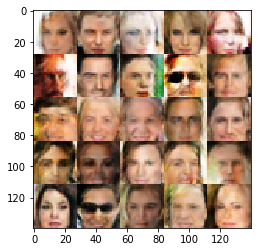

Epoch 1/1... Steps 5710     Discriminator Loss: 1.1859... Generator Loss: 0.7249
Epoch 1/1... Steps 5720     Discriminator Loss: 1.2087... Generator Loss: 0.9300
Epoch 1/1... Steps 5730     Discriminator Loss: 1.2443... Generator Loss: 0.6842
Epoch 1/1... Steps 5740     Discriminator Loss: 1.5035... Generator Loss: 0.4689
Epoch 1/1... Steps 5750     Discriminator Loss: 1.1531... Generator Loss: 0.7966
Epoch 1/1... Steps 5760     Discriminator Loss: 1.2229... Generator Loss: 0.8461
Epoch 1/1... Steps 5770     Discriminator Loss: 1.2264... Generator Loss: 0.6094
Epoch 1/1... Steps 5780     Discriminator Loss: 1.0783... Generator Loss: 1.0814
Epoch 1/1... Steps 5790     Discriminator Loss: 1.4619... Generator Loss: 0.5363
Epoch 1/1... Steps 5800     Discriminator Loss: 1.3167... Generator Loss: 0.6225


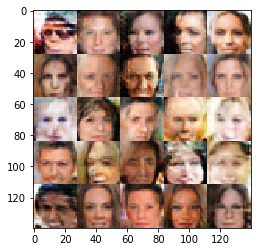

Epoch 1/1... Steps 5810     Discriminator Loss: 1.2823... Generator Loss: 0.8170
Epoch 1/1... Steps 5820     Discriminator Loss: 1.1650... Generator Loss: 0.8125
Epoch 1/1... Steps 5830     Discriminator Loss: 1.0326... Generator Loss: 2.4580
Epoch 1/1... Steps 5840     Discriminator Loss: 1.3628... Generator Loss: 0.5016
Epoch 1/1... Steps 5850     Discriminator Loss: 1.0751... Generator Loss: 1.0661
Epoch 1/1... Steps 5860     Discriminator Loss: 1.1583... Generator Loss: 0.7788
Epoch 1/1... Steps 5870     Discriminator Loss: 1.0546... Generator Loss: 1.0921
Epoch 1/1... Steps 5880     Discriminator Loss: 1.0635... Generator Loss: 1.4439
Epoch 1/1... Steps 5890     Discriminator Loss: 1.1751... Generator Loss: 0.8741
Epoch 1/1... Steps 5900     Discriminator Loss: 1.4204... Generator Loss: 0.5331


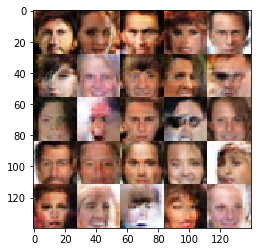

Epoch 1/1... Steps 5910     Discriminator Loss: 1.1895... Generator Loss: 1.0451
Epoch 1/1... Steps 5920     Discriminator Loss: 1.2672... Generator Loss: 0.9206
Epoch 1/1... Steps 5930     Discriminator Loss: 1.4345... Generator Loss: 0.5732
Epoch 1/1... Steps 5940     Discriminator Loss: 1.0945... Generator Loss: 1.0387
Epoch 1/1... Steps 5950     Discriminator Loss: 1.1032... Generator Loss: 0.8146
Epoch 1/1... Steps 5960     Discriminator Loss: 1.0162... Generator Loss: 1.3909
Epoch 1/1... Steps 5970     Discriminator Loss: 1.2222... Generator Loss: 0.7272
Epoch 1/1... Steps 5980     Discriminator Loss: 1.0981... Generator Loss: 1.3105
Epoch 1/1... Steps 5990     Discriminator Loss: 1.3105... Generator Loss: 0.6548
Epoch 1/1... Steps 6000     Discriminator Loss: 0.9652... Generator Loss: 1.1821


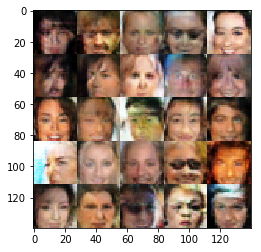

Epoch 1/1... Steps 6010     Discriminator Loss: 1.1885... Generator Loss: 1.0351
Epoch 1/1... Steps 6020     Discriminator Loss: 1.1163... Generator Loss: 1.0277
Epoch 1/1... Steps 6030     Discriminator Loss: 1.0833... Generator Loss: 1.1344
Epoch 1/1... Steps 6040     Discriminator Loss: 1.0846... Generator Loss: 1.1467
Epoch 1/1... Steps 6050     Discriminator Loss: 1.1899... Generator Loss: 0.7803
Epoch 1/1... Steps 6060     Discriminator Loss: 1.1562... Generator Loss: 0.8804
Epoch 1/1... Steps 6070     Discriminator Loss: 1.1086... Generator Loss: 1.3166
Epoch 1/1... Steps 6080     Discriminator Loss: 1.3656... Generator Loss: 1.9551
Epoch 1/1... Steps 6090     Discriminator Loss: 1.1597... Generator Loss: 0.8081
Epoch 1/1... Steps 6100     Discriminator Loss: 1.0749... Generator Loss: 1.5770


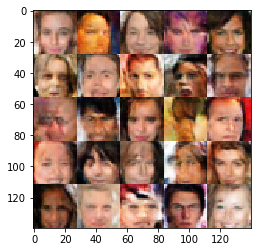

Epoch 1/1... Steps 6110     Discriminator Loss: 1.2029... Generator Loss: 0.7149
Epoch 1/1... Steps 6120     Discriminator Loss: 1.1210... Generator Loss: 0.9762
Epoch 1/1... Steps 6130     Discriminator Loss: 1.1754... Generator Loss: 1.0847
Epoch 1/1... Steps 6140     Discriminator Loss: 0.9626... Generator Loss: 1.1746
Epoch 1/1... Steps 6150     Discriminator Loss: 1.1953... Generator Loss: 1.0695
Epoch 1/1... Steps 6160     Discriminator Loss: 1.2718... Generator Loss: 0.6790
Epoch 1/1... Steps 6170     Discriminator Loss: 1.1180... Generator Loss: 1.1989
Epoch 1/1... Steps 6180     Discriminator Loss: 1.4550... Generator Loss: 0.4982
Epoch 1/1... Steps 6190     Discriminator Loss: 1.0607... Generator Loss: 1.1544
Epoch 1/1... Steps 6200     Discriminator Loss: 1.1923... Generator Loss: 0.9953


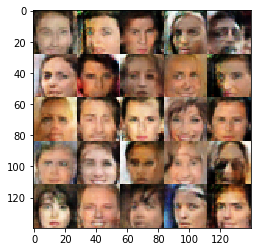

Epoch 1/1... Steps 6210     Discriminator Loss: 1.1519... Generator Loss: 0.7922
Epoch 1/1... Steps 6220     Discriminator Loss: 1.0767... Generator Loss: 0.8012
Epoch 1/1... Steps 6230     Discriminator Loss: 1.1098... Generator Loss: 1.0284
Epoch 1/1... Steps 6240     Discriminator Loss: 1.2523... Generator Loss: 0.9116
Epoch 1/1... Steps 6250     Discriminator Loss: 1.4909... Generator Loss: 0.4616
Epoch 1/1... Steps 6260     Discriminator Loss: 1.0977... Generator Loss: 1.0211
Epoch 1/1... Steps 6270     Discriminator Loss: 1.0159... Generator Loss: 1.1710
Epoch 1/1... Steps 6280     Discriminator Loss: 1.0828... Generator Loss: 0.9624
Epoch 1/1... Steps 6290     Discriminator Loss: 1.4338... Generator Loss: 0.5133
Epoch 1/1... Steps 6300     Discriminator Loss: 1.1024... Generator Loss: 1.1290


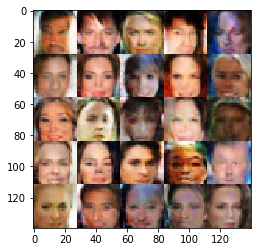

Epoch 1/1... Steps 6310     Discriminator Loss: 1.4640... Generator Loss: 0.4725
Epoch 1/1... Steps 6320     Discriminator Loss: 1.1266... Generator Loss: 1.1416
Epoch 1/1... Steps 6330     Discriminator Loss: 1.0354... Generator Loss: 0.8777


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.